# TP1 - Regresión
Notebook inicial para el trabajo práctico.

In [221]:
# 1. Importación de librerías necesarias
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import holidays

In [222]:
file_path= 'uber_fares.csv'
df = pd.read_csv(file_path)
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [223]:
# Se realiza un análisis inicial para comprender el comportamiento de cada variable.
df.info(), df.apply(pd.unique), df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


(None,
 key                  [24238194, 27835199, 44984355, 25894730, 17610...
 date                 [2015-05-07 19:52:06.0000003, 2009-07-17 20:04...
 fare_amount          [7.5, 7.7, 12.9, 5.3, 16.0, 4.9, 24.5, 2.5, 9....
 pickup_datetime      [2015-05-07 19:52:06 UTC, 2009-07-17 20:04:56 ...
 pickup_longitude     [-73.99981689453125, -73.994355, -74.005043, -...
 pickup_latitude      [40.73835372924805, 40.728225, 40.74077, 40.79...
 dropoff_longitude    [-73.99951171875, -73.99471, -73.962565, -73.9...
 dropoff_latitude     [40.72321701049805, 40.750325, 40.772647, 40.8...
 passenger_count                             [1, 3, 5, 2, 4, 6, 0, 208]
 dtype: object,
 key                  200000
 date                 200000
 fare_amount            1244
 pickup_datetime      196629
 pickup_longitude      71066
 pickup_latitude       83835
 dropoff_longitude     76894
 dropoff_latitude      90585
 passenger_count           8
 dtype: int64)

In [224]:
# Eliminar la columna 'key' porque no aporta al análisis
df = df.drop(columns=['key'])

In [225]:
# Análisis de redundancia entre 'date' y 'pickup_datetime'
print("Comparación entre las columnas 'date' y 'pickup_datetime':")
print("\nPrimeras 5 filas de ambas columnas:")
if 'date' in df.columns:
    print(df[['date', 'pickup_datetime']].head())
    
    
    df['fecha_extraida'] = pd.to_datetime(df['pickup_datetime']).dt.date
    df['date_convertida'] = pd.to_datetime(df['date']).dt.date if 'date' in df.columns else None
    
    print(f"\n¿Las fechas coinciden? {(df['fecha_extraida'] == df['date_convertida']).all()}")
    print(f"Número de coincidencias: {(df['fecha_extraida'] == df['date_convertida']).sum()}")
    print(f"Total de registros: {len(df)}")
    
    
    df = df.drop(columns=['fecha_extraida', 'date_convertida'])
else:
    print("La columna 'date' ya fue eliminada.")
    print("pickup_datetime contiene tanto la fecha como la hora:")
    print(df[['pickup_datetime']].head())
    print(f"\nTipo de datos: {df['pickup_datetime'].dtype}")
    print(f"Ejemplo de información temporal extraíble:")
    print(f"- Fecha: {pd.to_datetime(df['pickup_datetime']).dt.date.iloc[0]}")
    print(f"- Hora: {pd.to_datetime(df['pickup_datetime']).dt.time.iloc[0]}")
    print(f"- Año: {pd.to_datetime(df['pickup_datetime']).dt.year.iloc[0]}")
    print(f"- Mes: {pd.to_datetime(df['pickup_datetime']).dt.month.iloc[0]}")
    print(f"- Día: {pd.to_datetime(df['pickup_datetime']).dt.day.iloc[0]}")

Comparación entre las columnas 'date' y 'pickup_datetime':

Primeras 5 filas de ambas columnas:
                            date          pickup_datetime
0    2015-05-07 19:52:06.0000003  2015-05-07 19:52:06 UTC
1    2009-07-17 20:04:56.0000002  2009-07-17 20:04:56 UTC
2   2009-08-24 21:45:00.00000061  2009-08-24 21:45:00 UTC
3    2009-06-26 08:22:21.0000001  2009-06-26 08:22:21 UTC
4  2014-08-28 17:47:00.000000188  2014-08-28 17:47:00 UTC

¿Las fechas coinciden? True
Número de coincidencias: 200000
Total de registros: 200000


In [226]:
# Eliminamos la columna 'date' porque es completamente redundante con 'pickup_datetime'
# Ambas columnas contienen exactamente la misma información temporal
# pickup_datetime ya nos proporciona fecha y hora completa
df = df.drop(columns=['date'])

In [227]:
# Creamos nueva variable en base a la distancia entre coordenadas de inicio y fin del viaje utilizamos distancia haversine en km
def haversine(lat1, lon1, lat2, lon2):
    
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

df['dist_haversine'] = haversine(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude'])

In [228]:
# Creamos variable dummie para dias no laborables (feriados, sabados y domingos
feriados = holidays.US(state='NY')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['es_feriado'] = df['pickup_datetime'].dt.date.apply(lambda x: 1 if x in feriados else 0)
df['es_fin_de_semana'] = df['pickup_datetime'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
df['es_no_laborable'] = ((df['es_fin_de_semana'] == 1) | (df['es_feriado'] == 1)).astype(int)
df = df.drop(columns=['es_feriado', 'es_fin_de_semana'])

In [229]:
# Creamos la variable hora del dia para luego transformarla en variables circulares
df['hora_del_dia'] = df['pickup_datetime'].dt.hour
df['hora_sin'] = np.sin(2 * np.pi * df['hora_del_dia'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['hora_del_dia'] / 24)

In [230]:
# Creamos variable dummie para la quincena del mes
df['1era_mitad_mes'] = (df['pickup_datetime'].dt.day < 15).astype(int)

In [231]:
# Creamos variables dummie para las estaciones del ano
df['pickup_datetime'] = df['pickup_datetime'].dt.tz_localize(None)

def estacion_astronomica(fecha):
    y = fecha.year
    if fecha >= pd.Timestamp(y, 12, 21) or fecha < pd.Timestamp(y, 3, 20):
        return 'invierno'
    elif fecha >= pd.Timestamp(y, 3, 20) and fecha < pd.Timestamp(y, 6, 21):
        return 'primavera'
    elif fecha >= pd.Timestamp(y, 6, 21) and fecha < pd.Timestamp(y, 9, 22):
        return 'verano'
    else:
        return 'otoño'

df['estacion'] = df['pickup_datetime'].apply(estacion_astronomica)

dummies = pd.get_dummies(df['estacion'], prefix='', prefix_sep='')
for estacion in ['invierno', 'primavera', 'verano']:
    df[estacion] = dummies.get(estacion, pd.Series(0, index=df.index)).astype(int)

df = df.drop(columns=['estacion'])

In [232]:
# Análisis de la variable passenger_count para entender su distribución y crear dummies
df['passenger_count'].value_counts()

passenger_count
1      138425
2       29428
5       14009
3        8881
4        4276
6        4271
0         709
208         1
Name: count, dtype: int64

In [ ]:
# Eliminamos filas donde passenger_count sea mayor a 6, ya que no son representativas y pueden distorsionar el análisis
df = df[df['passenger_count'] <= 6]

In [233]:
# Crear variables dummies para passenger_count
df['delivery'] = (df['passenger_count'] == 0).astype(int)
df['standard'] = df['passenger_count'].between(1, 4).astype(int)

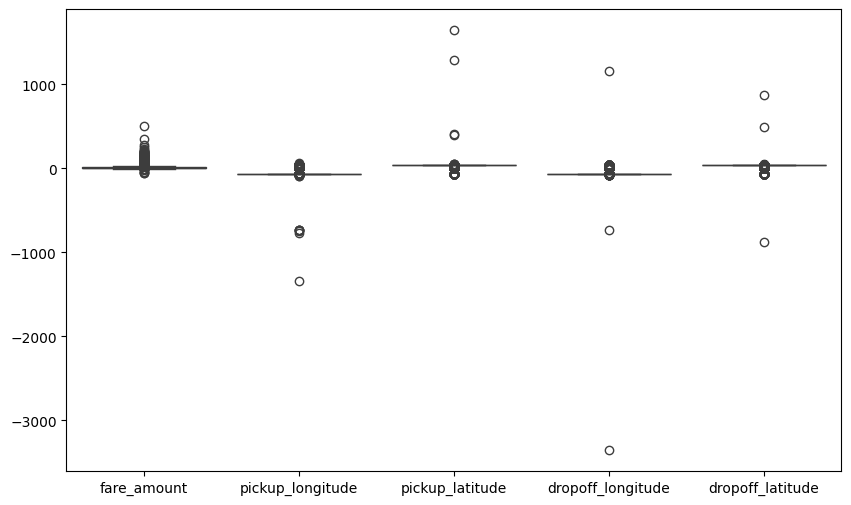

In [234]:
# Notamos que en fare_amount y en las coordenadas hay valores erroneos
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])
plt.show()

In [235]:
# Eliminamos registros fuera del área aproximada de Nueva York
# Rango típico NYC: latitud 40.5 a 41, longitud -74.25 a -73.7

ny_lat_min, ny_lat_max = 40.5, 41.0
ny_lon_min, ny_lon_max = -74.25, -73.7

mask_pickup = (
    (df['pickup_latitude'] >= ny_lat_min) & (df['pickup_latitude'] <= ny_lat_max) &
    (df['pickup_longitude'] >= ny_lon_min) & (df['pickup_longitude'] <= ny_lon_max)
)

mask_dropoff = (
    (df['dropoff_latitude'] >= ny_lat_min) & (df['dropoff_latitude'] <= ny_lat_max) &
    (df['dropoff_longitude'] >= ny_lon_min) & (df['dropoff_longitude'] <= ny_lon_max)
)

df = df[mask_pickup & mask_dropoff]

In [236]:
# Previo a la imputacion realizamos la división en train y test (80% - 20%)
y = df["fare_amount"]
X = df.drop(columns=["fare_amount"])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# Detectamos valores negativos y algunos muy bajos en fare_ammount. Al ver que son pocos y considerarlos errores procedemos a su eliminación.
df_train['fare_amount'].value_counts().sort_index().head(20)


fare_amount
-52.00      1
-50.50      1
-49.57      1
-23.70      1
-10.90      1
-7.30       1
-6.90       1
-5.70       1
-5.50       1
-5.00       1
-3.50       3
-3.30       1
-3.00       2
 0.00       2
 0.01       2
 0.11       1
 2.50     714
 2.90     469
 3.00     346
 3.25       1
Name: count, dtype: int64

In [ ]:
df_train = df_train[df_train['fare_amount'] > 0.11]

In [240]:
# Consideramos que todo viaje menor a 100 metros deber ser un error de carga o probablemente sea mas largo de la distancia entre partida y llegada.

df_train.loc[df_train['dist_haversine'] < 0.1, 'dist_haversine'] = np.nan
dftrain_valid = df_train[~df_train['dist_haversine'].isna()]


In [241]:
# Registros con logitudes y latitudes iguales, es probable que este tipo de registros sean de viajes que empiezan y terminan en el mismo lugar.
# Tambien consideramos que la cantidad de registros es importante por eso creemos necesaria su imputacion.
mask = (df_train['pickup_longitude'] == df_train['dropoff_longitude']) & (df_train['pickup_latitude'] == df_train['dropoff_latitude'])
registros_iguales = df_train[mask]
print(f"Cantidad de registros con misma lat/lon de origen y destino: {registros_iguales.shape[0]}")
registros_iguales

Cantidad de registros con misma lat/lon de origen y destino: 1541


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_haversine,es_no_laborable,hora_del_dia,hora_sin,hora_cos,1era_mitad_mes,invierno,primavera,verano,delivery,standard
176303,6.9,2010-05-01 21:58:00,-73.837155,40.740862,-73.837155,40.740862,1,NaN,1,21,-0.707107,0.707107,1,0,1,0,0,1
120449,89.0,2013-06-24 16:40:08,-73.893936,40.798476,-73.893936,40.798476,1,NaN,0,16,-0.866025,-0.500000,0,0,0,1,0,1
92500,12.5,2012-04-02 22:43:25,-73.965026,40.687136,-73.965026,40.687136,2,NaN,0,22,-0.500000,0.866025,1,0,1,0,0,1
158829,2.5,2012-05-12 15:36:51,-73.939116,40.750371,-73.939116,40.750371,1,NaN,1,15,-0.707107,-0.707107,1,0,1,0,0,1
180696,8.9,2011-04-04 23:47:02,-73.962535,40.770438,-73.962535,40.770438,2,NaN,0,23,-0.258819,0.965926,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98804,28.0,2014-11-19 23:42:43,-73.966395,40.804978,-73.966395,40.804978,1,NaN,0,23,-0.258819,0.965926,0,0,0,0,0,1
130585,9.0,2013-08-31 13:01:53,-73.999558,40.722099,-73.999558,40.722099,1,NaN,1,13,-0.258819,-0.965926,0,0,0,1,0,1
196647,200.0,2010-08-19 16:52:45,-73.952994,40.736298,-73.952994,40.736298,1,NaN,0,16,-0.866025,-0.500000,0,0,0,1,0,1
41296,4.1,2009-01-01 15:12:00,-73.977895,40.787628,-73.977895,40.787628,3,NaN,1,15,-0.707107,-0.707107,1,1,0,0,0,1


In [242]:
# Entrenamos un modelo de regresión lineal para imputar las distancias en relacion al fare_amount

X = dftrain_valid[['fare_amount']]  # fare_amount como predictor
y = dftrain_valid['dist_haversine'] # dist_haversine como target

model = LinearRegression()
model.fit(X, y)


mask_missing = df_train['dist_haversine'].isna()
df_train.loc[mask_missing, 'dist_haversine'] = model.predict(df_train.loc[mask_missing, ['fare_amount']])
df_train.loc[mask_missing, 'dist_haversine'] = df_train.loc[mask_missing, 'dist_haversine'].clip(lower=0)


In [243]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156457 entries, 87331 to 124768
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   fare_amount        156457 non-null  float64       
 1   pickup_datetime    156457 non-null  datetime64[ns]
 2   pickup_longitude   156457 non-null  float64       
 3   pickup_latitude    156457 non-null  float64       
 4   dropoff_longitude  156457 non-null  float64       
 5   dropoff_latitude   156457 non-null  float64       
 6   passenger_count    156457 non-null  int64         
 7   dist_haversine     156457 non-null  float64       
 8   es_no_laborable    156457 non-null  int64         
 9   hora_del_dia       156457 non-null  int32         
 10  hora_sin           156457 non-null  float64       
 11  hora_cos           156457 non-null  float64       
 12  1era_mitad_mes     156457 non-null  int64         
 13  invierno           156457 non-null  int64    

In [244]:
# Eliminamos columnas que no aportan al análisis
df_train = df_train.drop(columns=['pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude',
    'passenger_count', 'hora_del_dia', 'pickup_datetime'
])


df_test = df_test.drop(columns=['pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude',
    'passenger_count', 'hora_del_dia', 'pickup_datetime'
])

In [245]:
# Separar variables predictoras y target en train y test
X_train = df_train.drop(columns=['fare_amount'])
y_train = df_train['fare_amount']

X_test = df_test.drop(columns=['fare_amount'])
y_test = df_test['fare_amount']

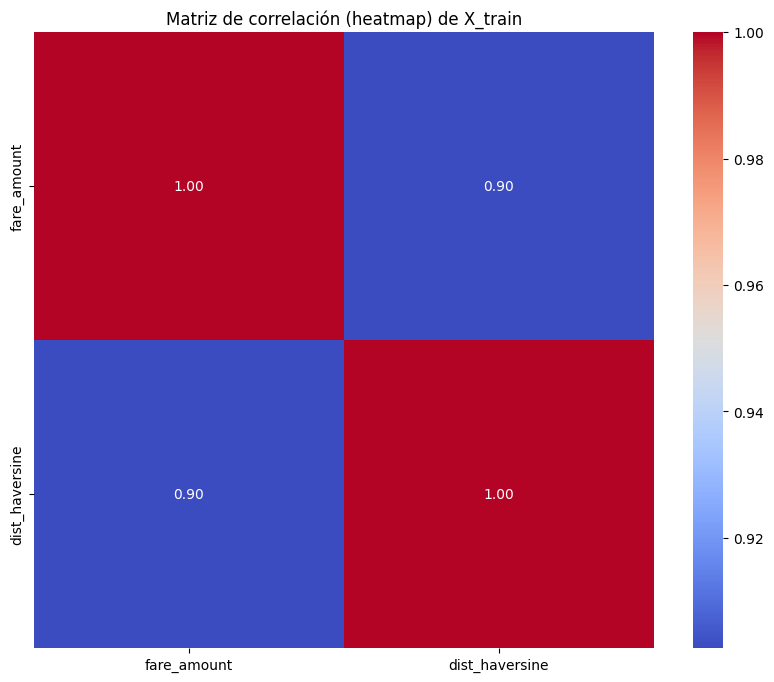

In [246]:
# Heatmap de la matriz de correlación de X_train
corr_matrix = df_train[['fare_amount', 'dist_haversine']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación (heatmap) de X_train')
plt.show()

In [247]:
# Escalamos variables y realizamos la regresion lineal
scaler = StandardScaler()
X_train['dist_haversine'] = scaler.fit_transform(X_train[['dist_haversine']])
X_test['dist_haversine'] = scaler.transform(X_test[['dist_haversine']])


scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


modelo = LinearRegression()
modelo.fit(X_train, y_train_scaled)
predicciones = modelo.predict(X_test)
predicciones = predicciones.flatten()



predicciones_descaled = scaler_y.inverse_transform(predicciones.reshape(-1, 1))
rmse_ols = np.sqrt(mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones_descaled,
           ))

print(f"El RMSE de test es: {rmse_ols}")
R2_lr = r2_score(y_test, predicciones_descaled)
print(f"R2 = {R2_lr}")

El RMSE de test es: 4.625236072608577
R2 = 0.7674738261149339


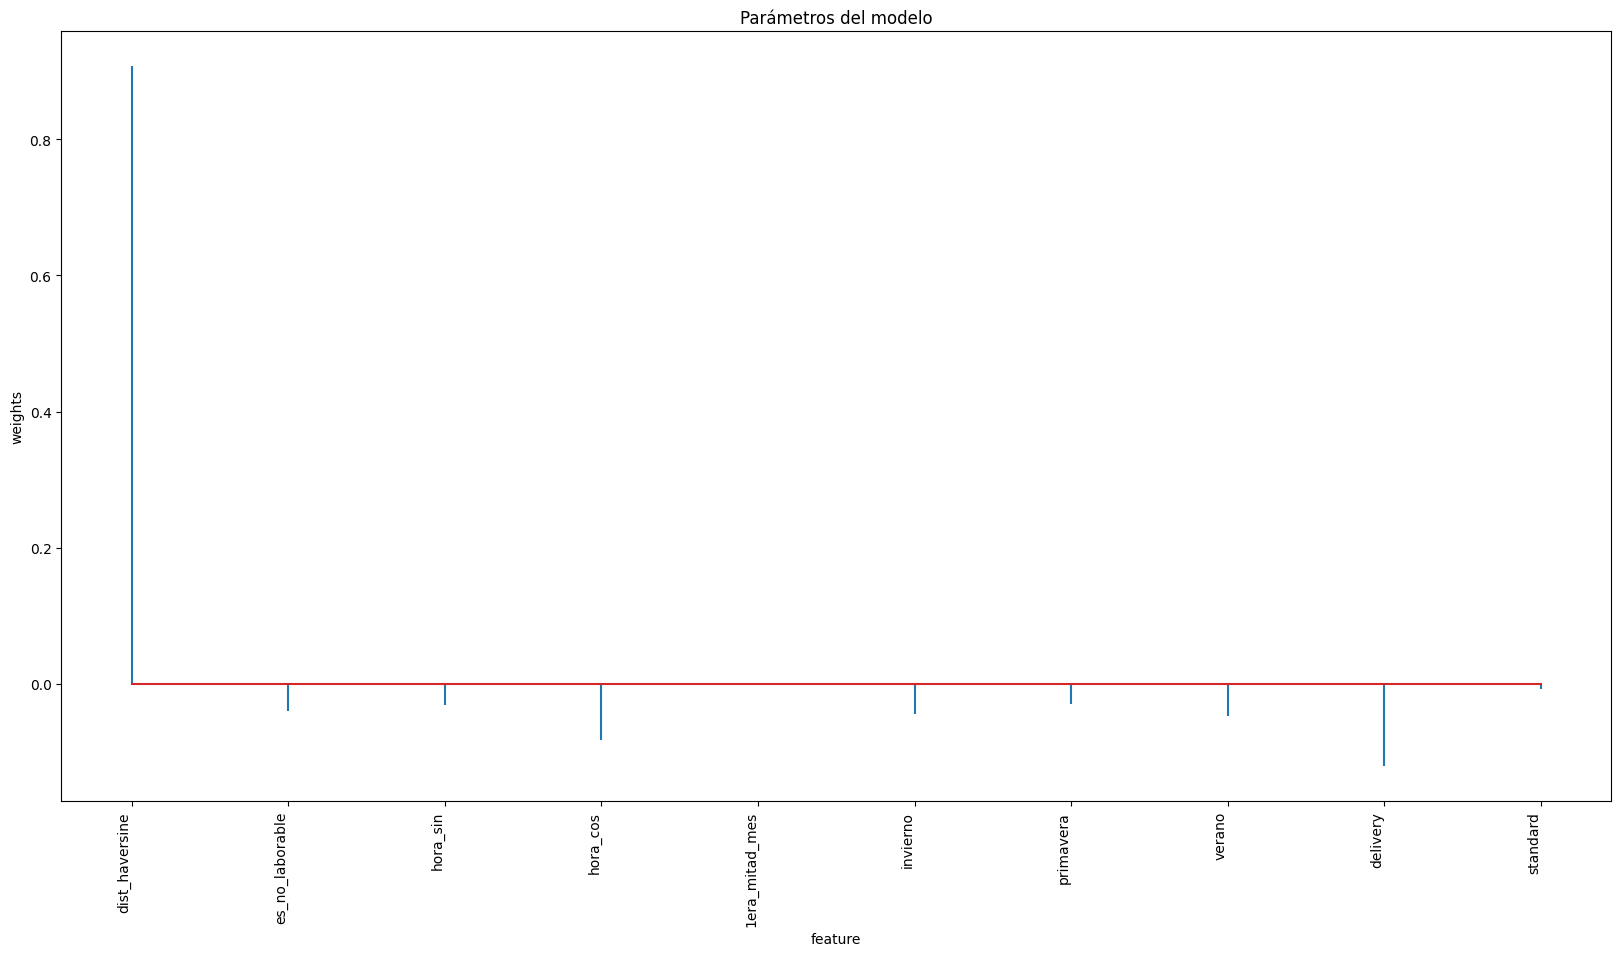

In [248]:
# Visualizamos los coeficientes del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

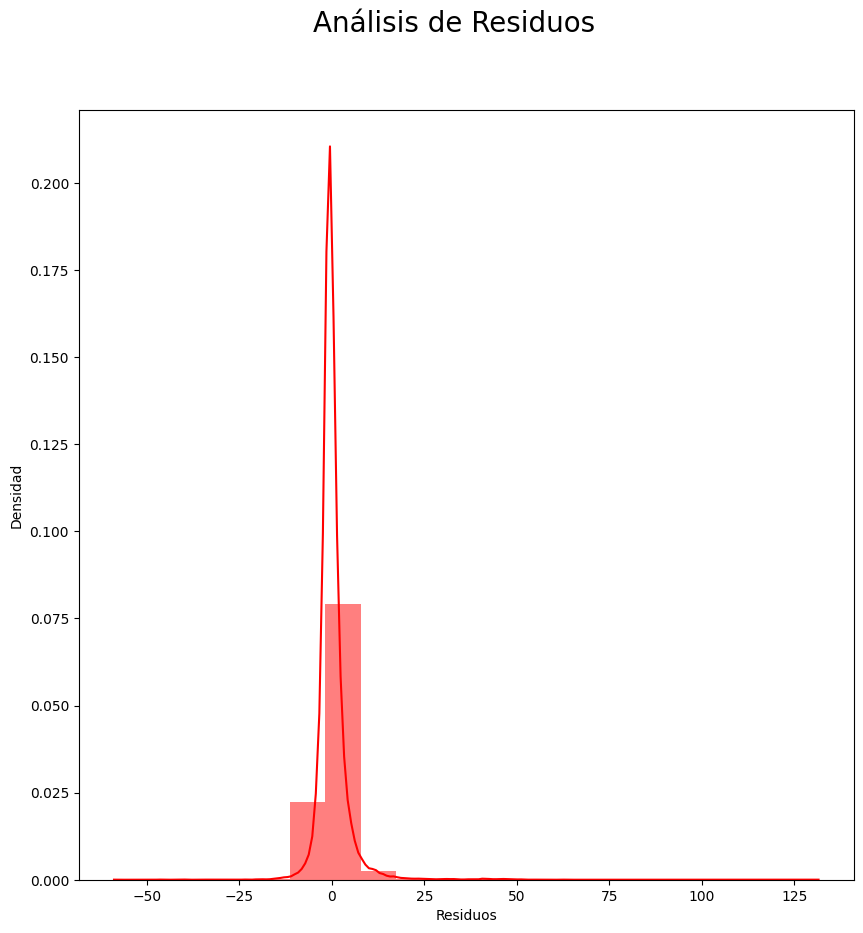

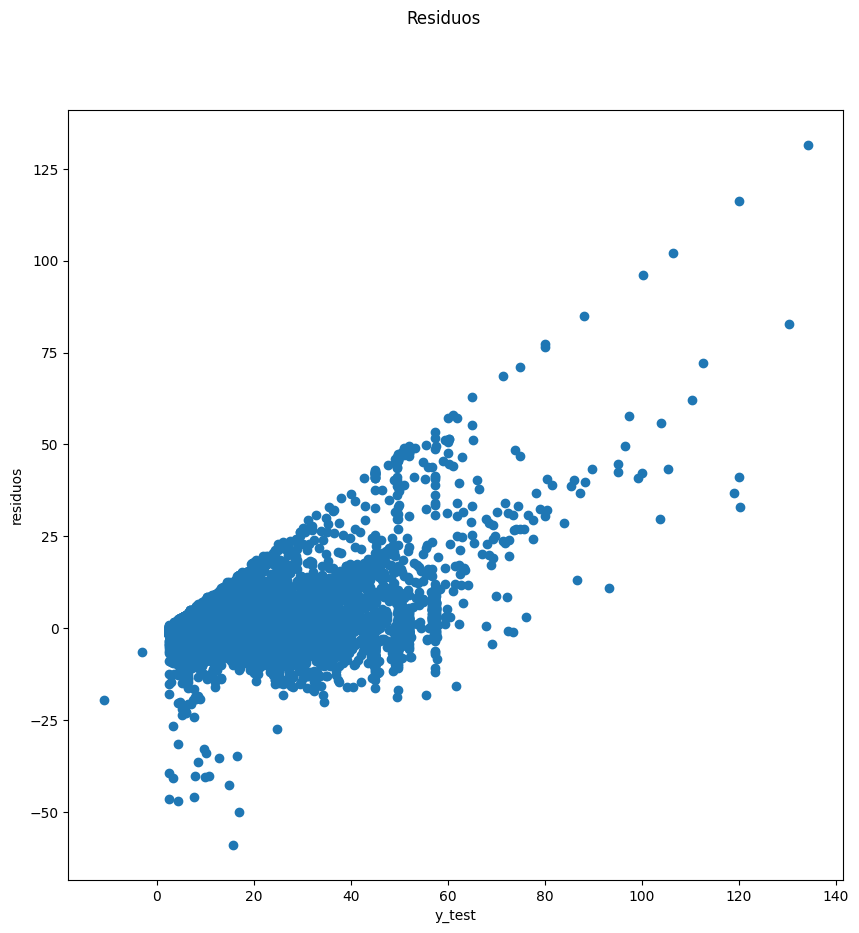

In [249]:
# Analizamos los residuos
fig = plt.figure(figsize=(10,10))
residuos = y_test - predicciones_descaled.reshape(y_test.shape)
sns.histplot(residuos, color="red", kde=True, stat="density", linewidth=0, bins=20)
fig.suptitle('Análisis de Residuos', fontsize=20)
plt.xlabel('Residuos')
plt.ylabel('Densidad')
plt.show()

fig = plt.figure(figsize=(10,10))
fig.suptitle('Residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test, y_test - predicciones_descaled.flatten())
plt.show()

Podemos evidenciar que en el gráfico de residuos, el pico más alto de la distribución se encuentra cercano al cero. En principio, puede ser bueno, ya que, en promedio, la mayoría de sus errores son pequeños. Sin embargo, presenta una fuerte asimetría positiva lo que indica que el modelo comete algunos errores muy grandes, subestimando el valor real. Por lo tanto, no podríamos afirmar que es un modelo fiable.

In [250]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  
    test_errors = []
    for _ in range(epochs):
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  
        gradient = np.transpose(grad_mul).reshape(-1, 1) 

        W = W - (lr * gradient)

   
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title(f'Error de entrenamiento y validación vs iteraciones (GD) lr={lr}, e={epochs}')
    plt.show()

    return W

In [251]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title(f'Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD) lr={lr}, e={epochs} bs={batch_size}')
    plt.show()

    return W

In [252]:
def gradiente_descendiente_estocastico(X_train, y_train, X_test, y_test, lr=0.01, epochs=10, batch_size=1):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title(f'Error de entrenamiento y prueba vs iteraciones (GDS) lr={lr}, e={epochs}')
    plt.show()

    return W

In [253]:
# Creamos conjunto de validacion a partir del conjunto de entrenamiento para usar en el gradiente descendiente
x_train_gd, x_val_gd, y_train_gd, y_val_gd = train_test_split(
    X_train.values, y_train_scaled, test_size=0.2, random_state=42
)

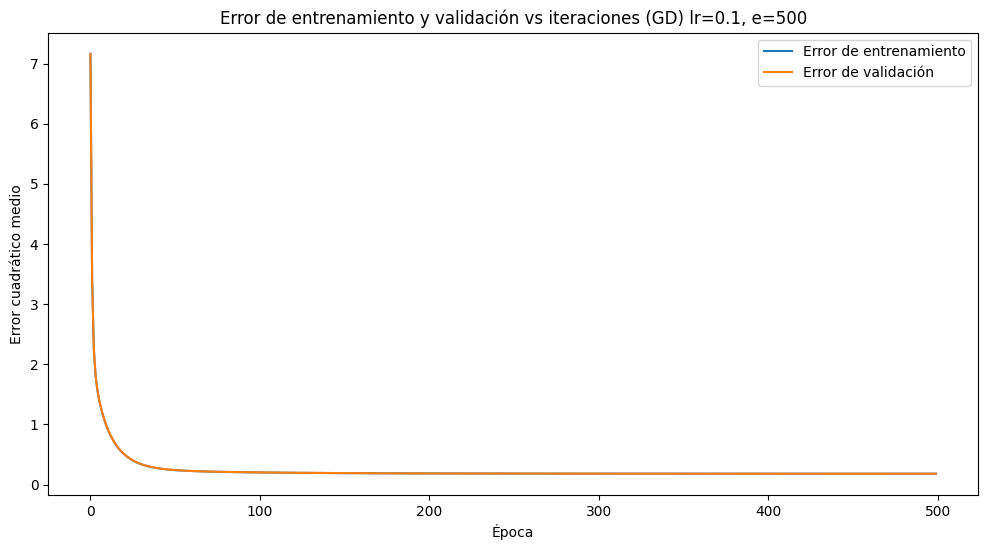

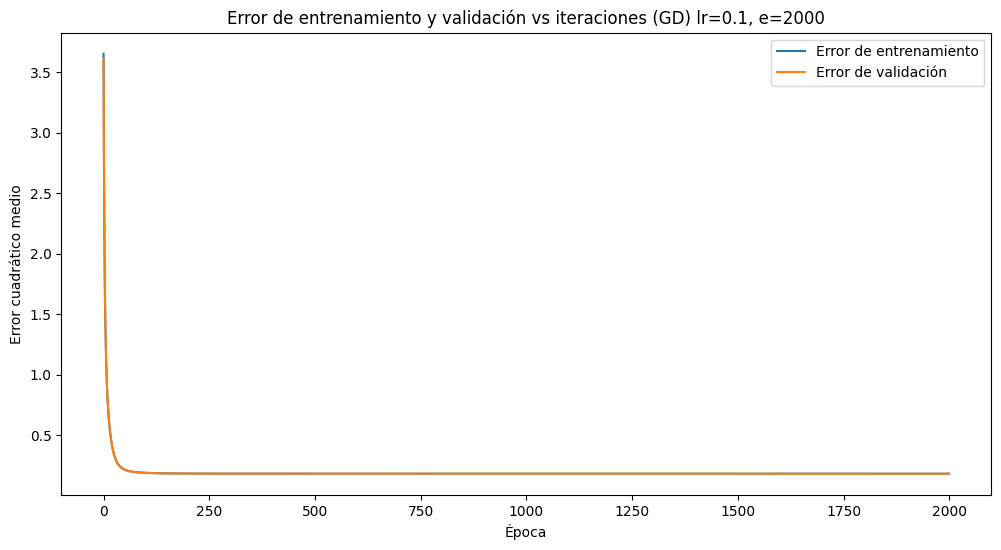

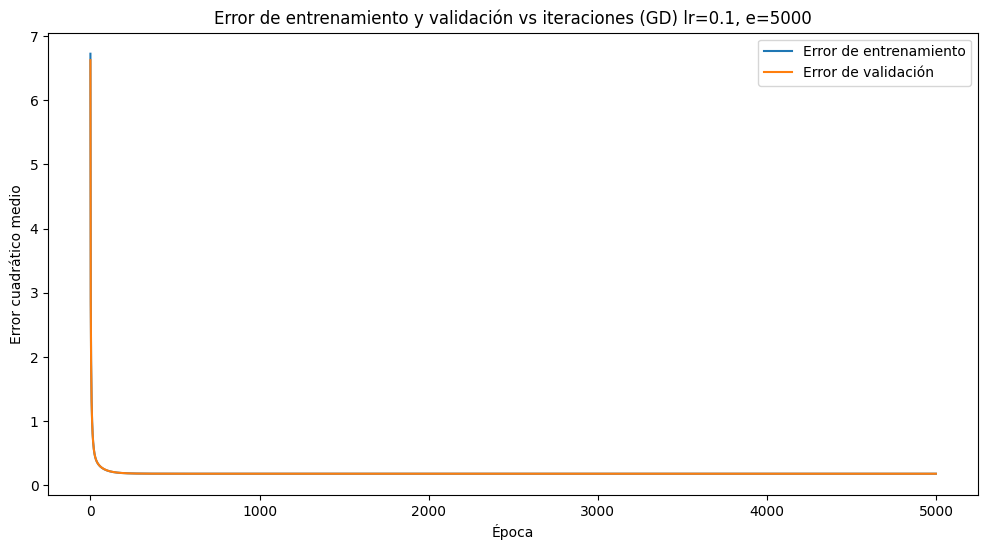

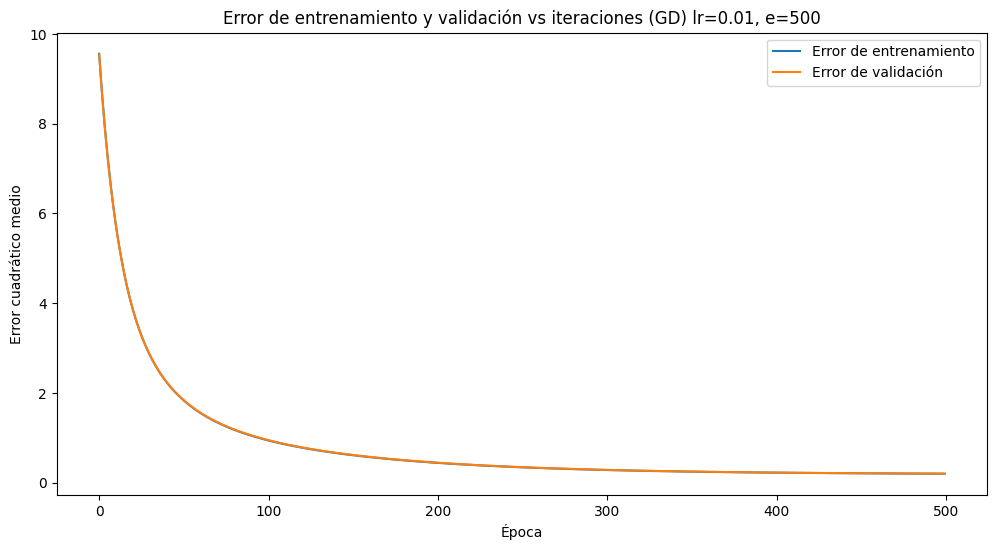

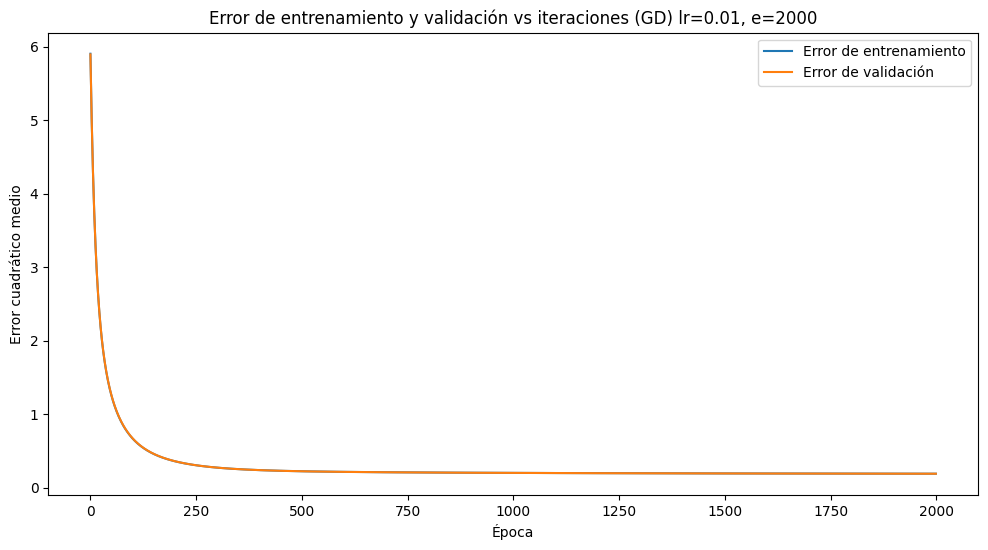

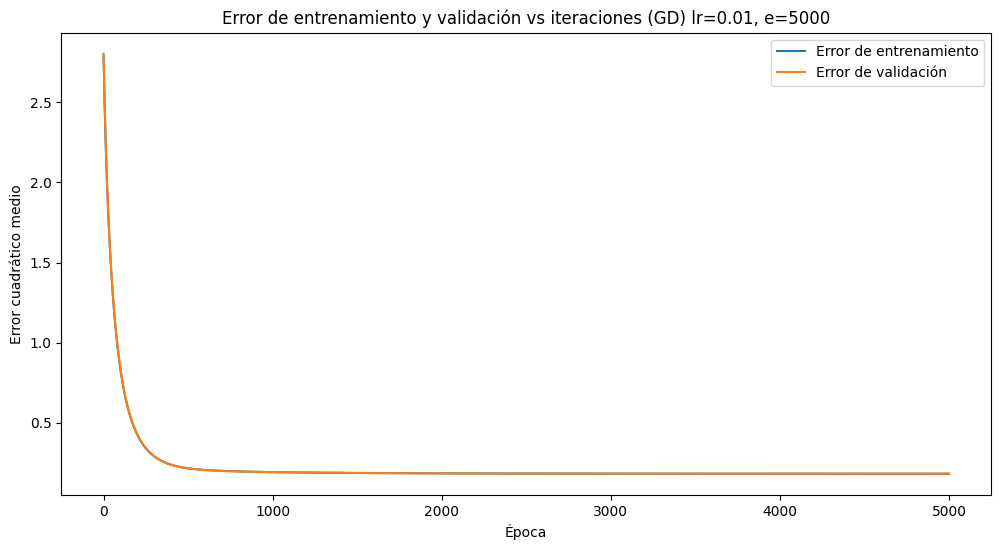

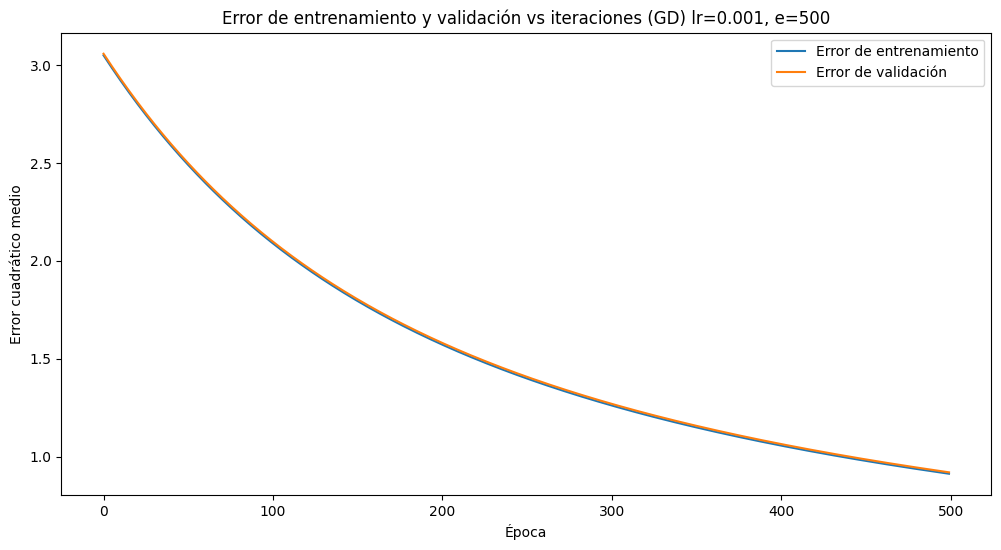

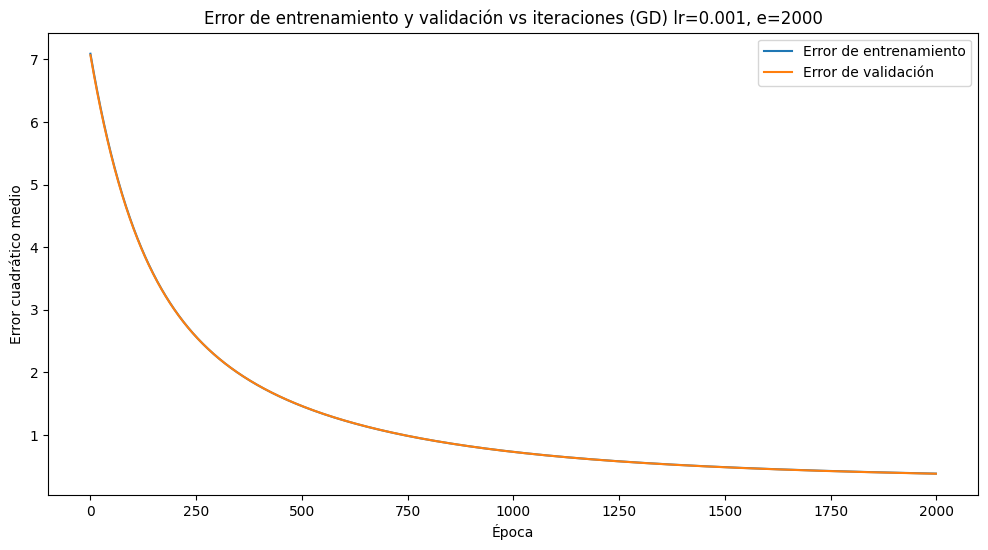

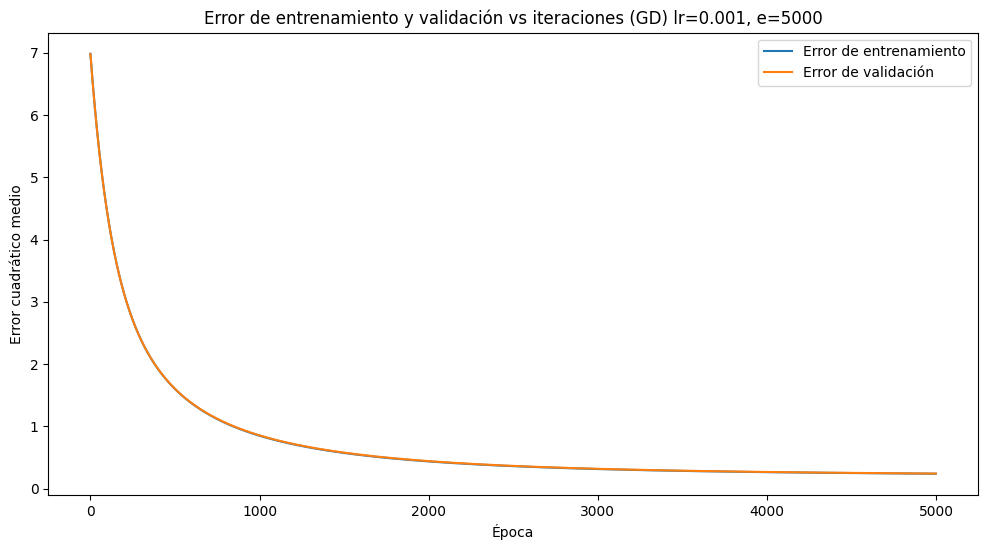

In [254]:
# Probamos distintos learning rates y epochs para ver su impacto en el error
learning_rates = [0.1, 0.01, 0.001]
epochs_list = [500, 2000, 5000]

for lr in learning_rates:
    for epochs in epochs_list:
        coef_gradiente = gradient_descent(
            x_train_gd, y_train_gd, x_val_gd, y_val_gd,
            lr=lr,
            epochs=epochs
        )

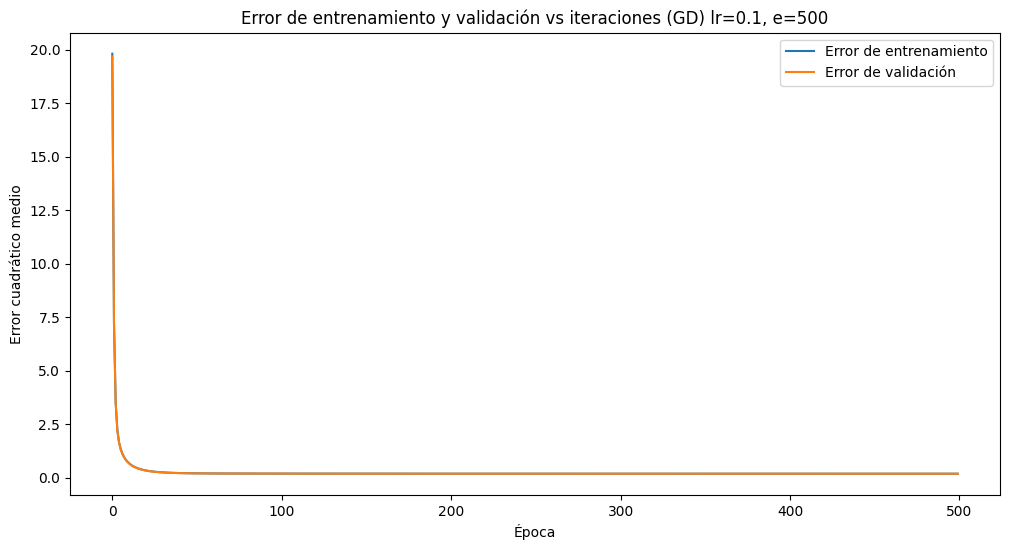

In [255]:
# Nos quedamos con los mejores hiperparametros y entrenamos el modelo
coef_gradiente = gradient_descent(x_train_gd, y_train_gd, x_val_gd, y_val_gd, lr=0.1, epochs=500)

In [256]:
# Evaluamos el modelo en el conjunto de test
X_test_gd = np.hstack((np.ones((X_test.shape[0], 1)), X_test.values))

y_pred_gd = np.matmul(X_test_gd, coef_gradiente)
y_pred_gd_descaled = scaler_y.inverse_transform(y_pred_gd.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_gd_descaled)
rmse_gd = np.sqrt(mse)
R2_gd = r2_score(y_test, y_pred_gd_descaled)


print(f"El RMSE es: {rmse_gd}")
print(f"R2: {R2_gd}")


El RMSE es: 4.635272057424522
R2: 0.7664636459186182


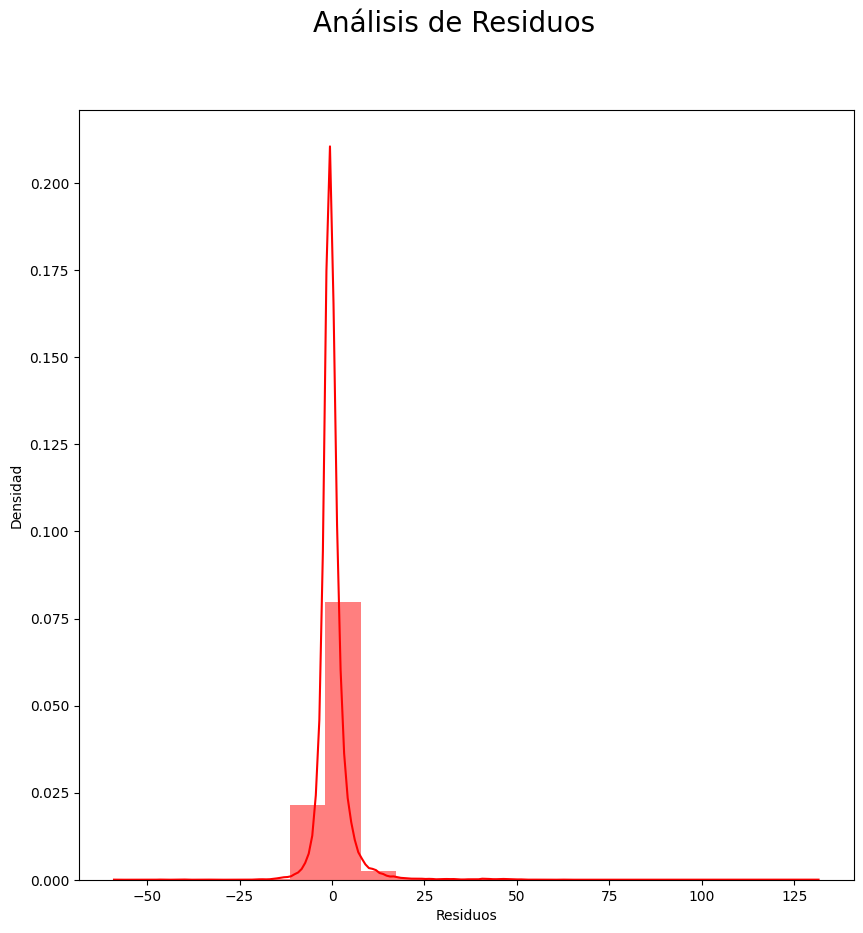

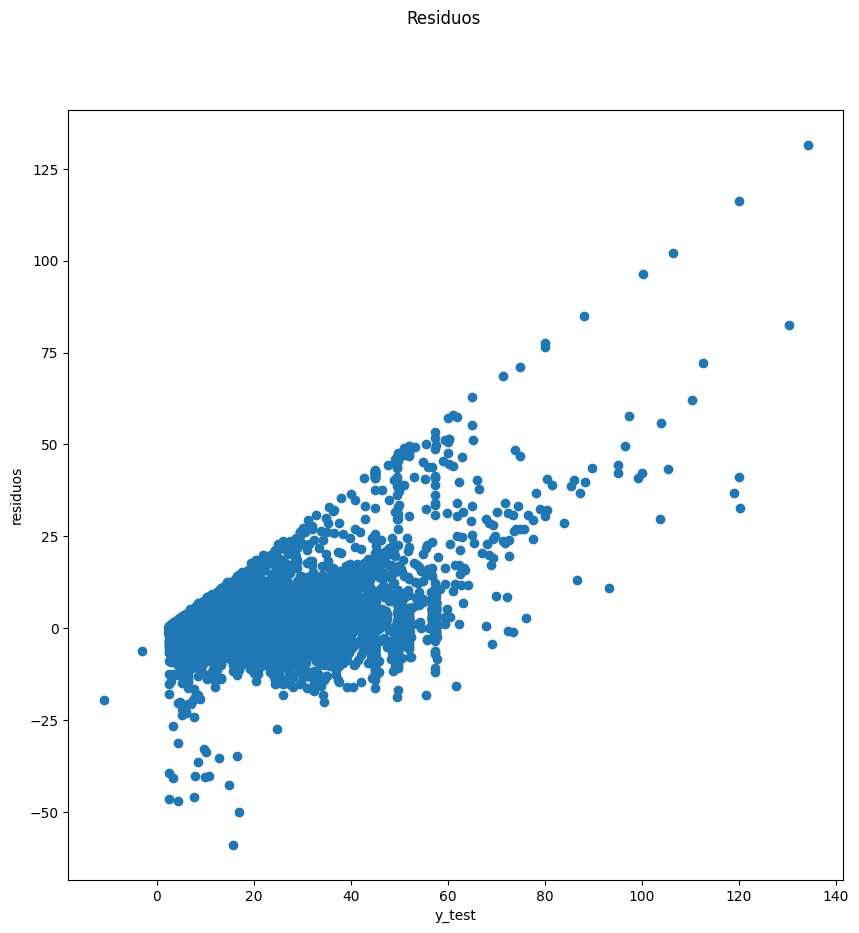

In [257]:
# Analizamos los residuos
fig = plt.figure(figsize=(10,10))
residuos = y_test - y_pred_gd_descaled.reshape(y_test.shape)
sns.histplot(residuos, color="red", kde=True, stat="density", linewidth=0, bins=20)
fig.suptitle('Análisis de Residuos', fontsize=20)
plt.xlabel('Residuos')
plt.ylabel('Densidad')
plt.show()

fig = plt.figure(figsize=(10,10))
fig.suptitle('Residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test, y_test - y_pred_gd_descaled.flatten())
plt.show()

Podemos evidenciar que en el gráfico de residuos, el pico más alto de la distribución se encuentra cercano al cero. En principio, puede ser bueno, ya que, en promedio, la mayoría de sus errores son pequeños. Sin embargo, presenta una fuerte asimetría positiva lo que indica que el modelo comete algunos errores muy grandes, subestimando el valor real. Por lo tanto, no podríamos afirmar que es un modelo fiable.

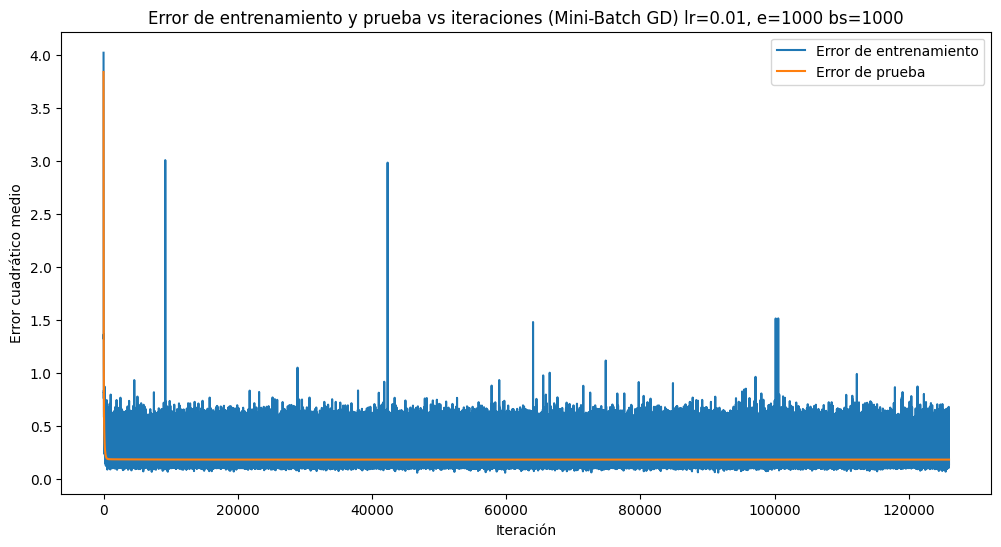

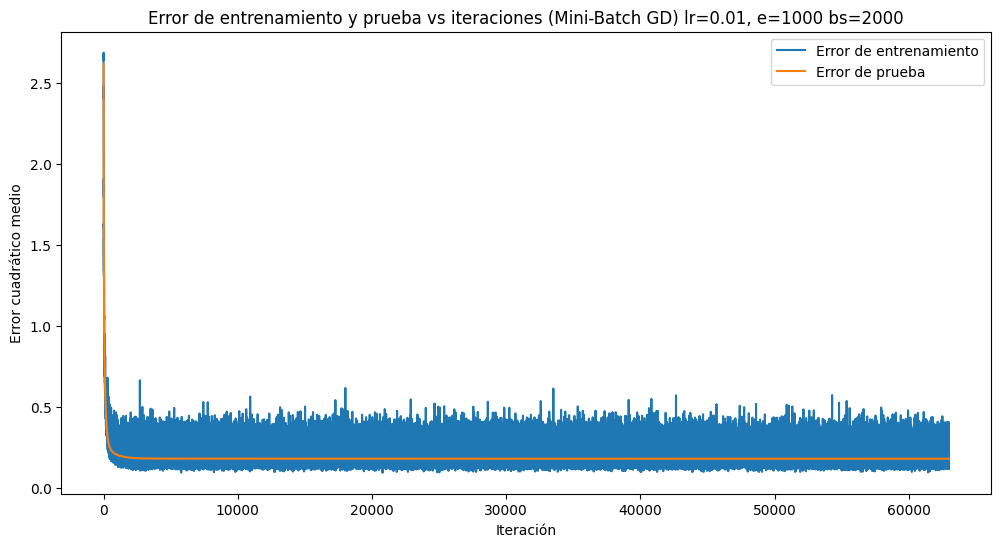

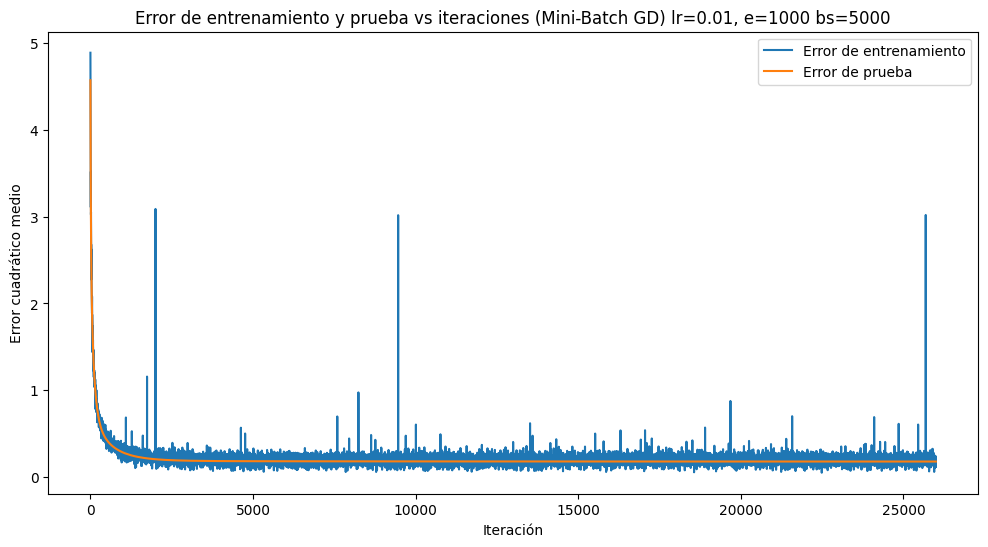

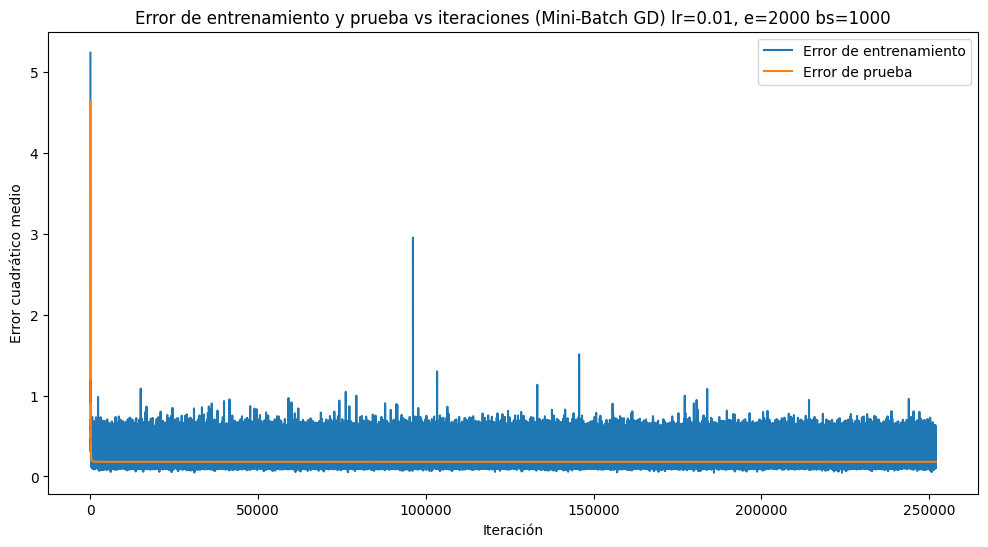

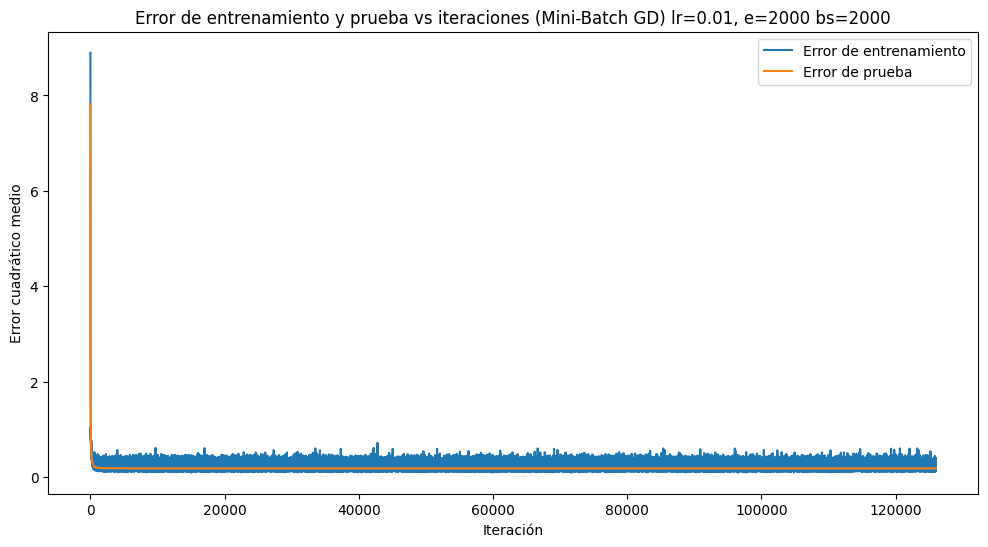

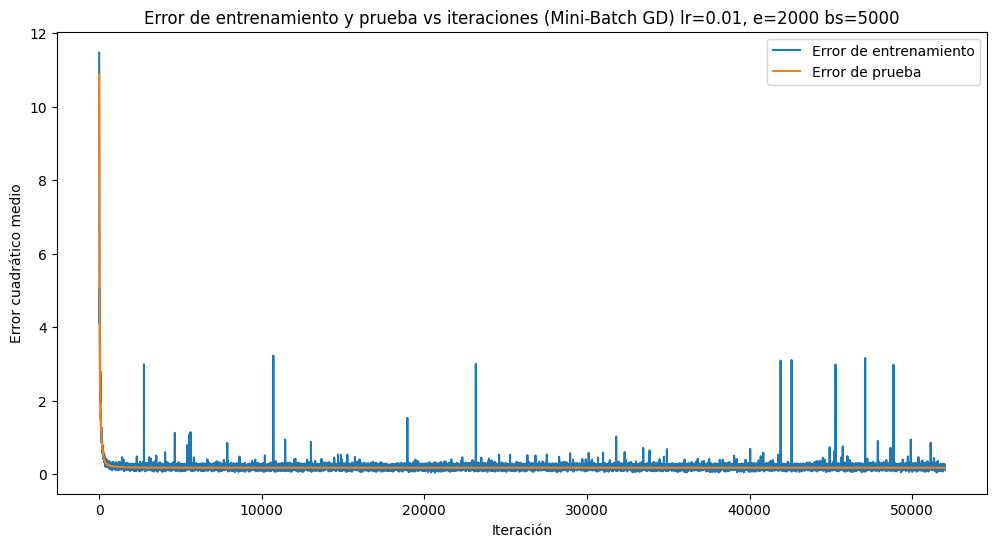

In [258]:
# Probamos distintos batch sizes y epochs para ver su impacto en el error
batchs = [1000, 2000, 5000]
epochs_list = [1000, 2000]
lr = 0.01
for epochs in epochs_list:
    for batch in batchs:
        coef_gradiente = mini_batch_gradient_descent(
            x_train_gd, y_train_gd, x_val_gd, y_val_gd,
            epochs=epochs,
            lr=lr,
            batch_size=batch
        )

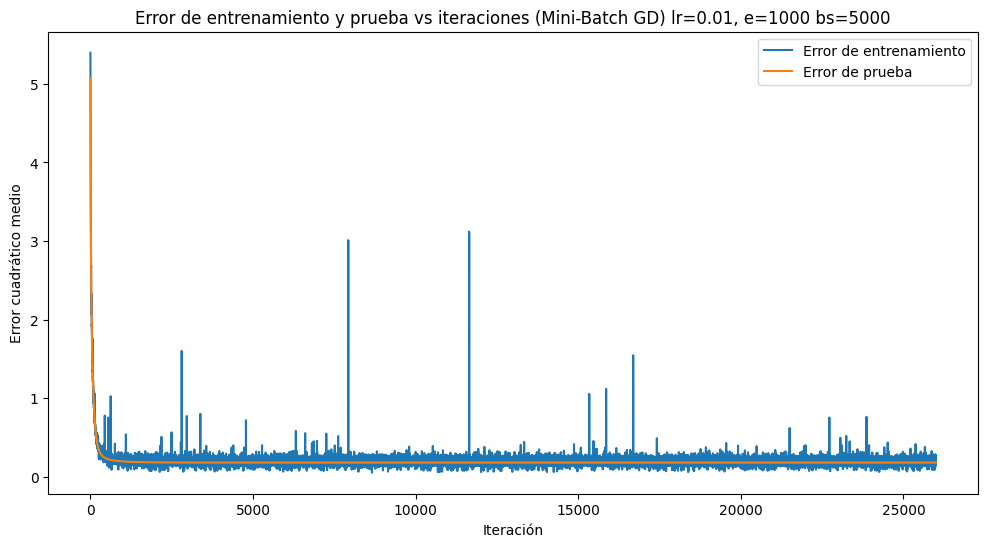

In [259]:
# Nos quedamos con los mejores hiperparametros y entrenamos el modelo
coef_gmini = mini_batch_gradient_descent(x_train_gd, y_train_gd, x_val_gd, y_val_gd, lr=0.01, epochs=1000, batch_size=5000)

In [260]:
# Evaluamos el modelo en el conjunto de test
X_test_gd = np.hstack((np.ones((X_test.shape[0], 1)), X_test.values))
y_pred_gd = np.matmul(X_test_gd, coef_gmini)
y_pred_gd_descaled = scaler_y.inverse_transform(y_pred_gd.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_gd_descaled)
rmse_gmini = np.sqrt(mse)
R2_gmini = r2_score(y_test, y_pred_gd_descaled)


print(f"El RMSE es: {rmse_gmini}")
print(f"R2: {R2_gmini}")


El RMSE es: 4.625556418330723
R2: 0.7674416152856992


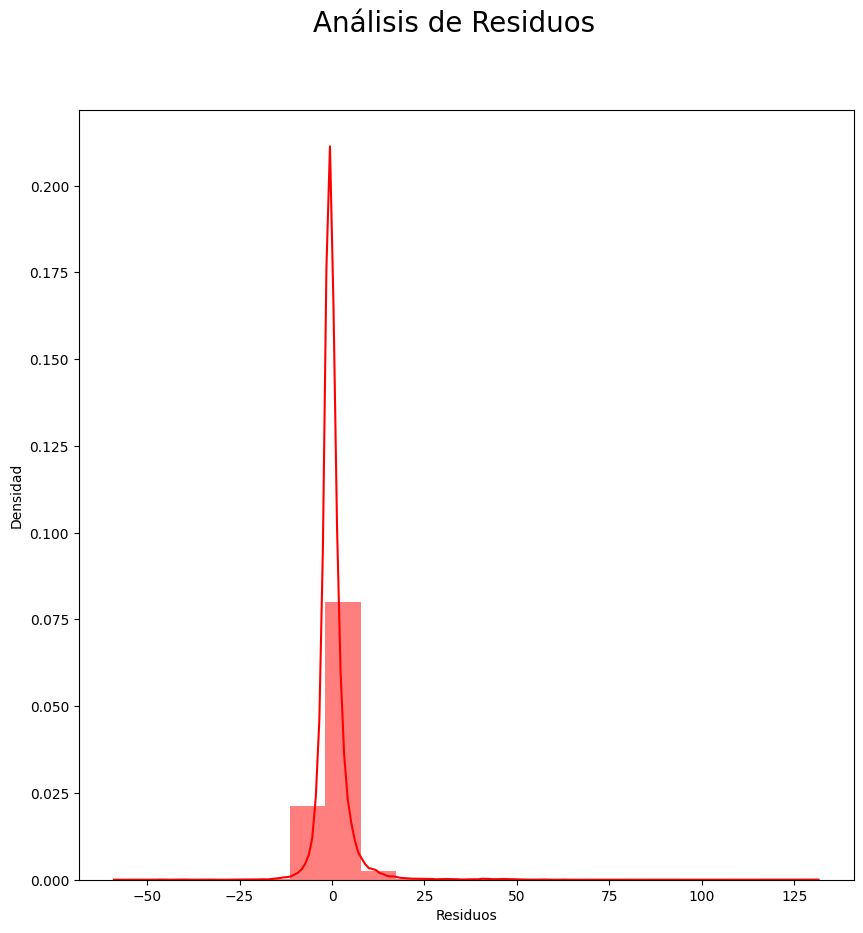

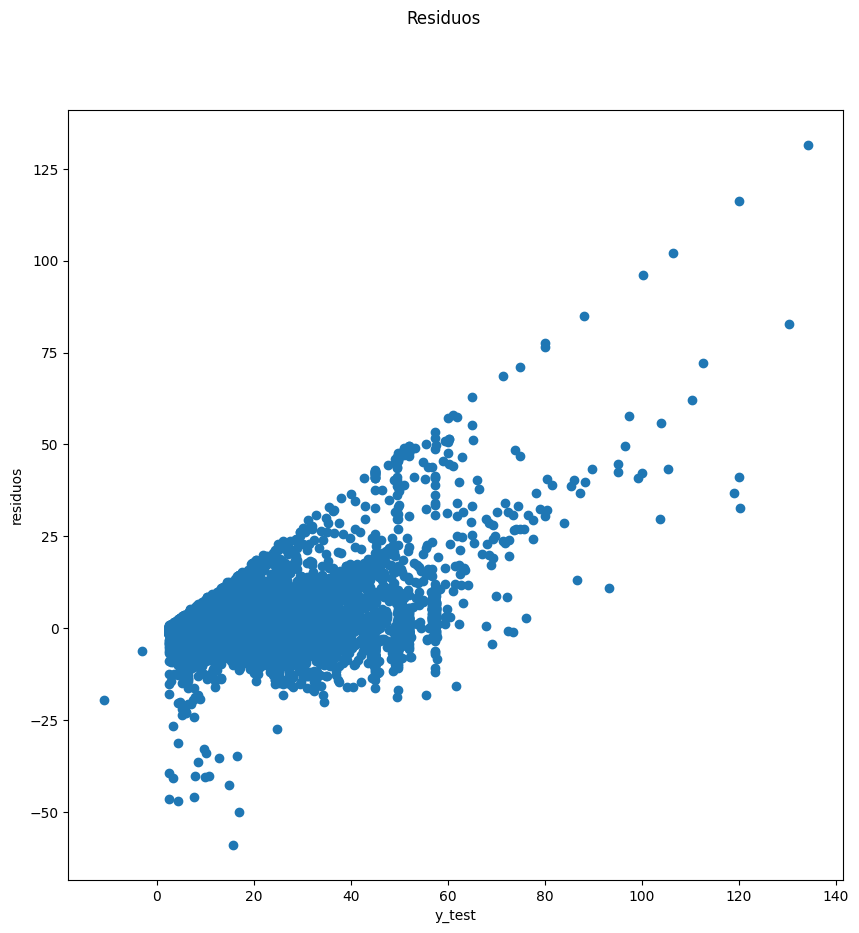

In [261]:
# Analizamos los residuos
fig = plt.figure(figsize=(10,10))
residuos = y_test - y_pred_gd_descaled.reshape(y_test.shape)
sns.histplot(residuos, color="red", kde=True, stat="density", linewidth=0, bins=20)
fig.suptitle('Análisis de Residuos', fontsize=20)
plt.xlabel('Residuos')
plt.ylabel('Densidad')
plt.show()

fig = plt.figure(figsize=(10,10))
fig.suptitle('Residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test, y_test - y_pred_gd_descaled.flatten())
plt.show()

Podemos evidenciar que en el gráfico de residuos, el pico más alto de la distribución se encuentra cercano al cero. En principio, puede ser bueno, ya que, en promedio, la mayoría de sus errores son pequeños. Sin embargo, presenta una fuerte asimetría positiva lo que indica que el modelo comete algunos errores muy grandes, subestimando el valor real. Por lo tanto, no podríamos afirmar que es un modelo fiable.

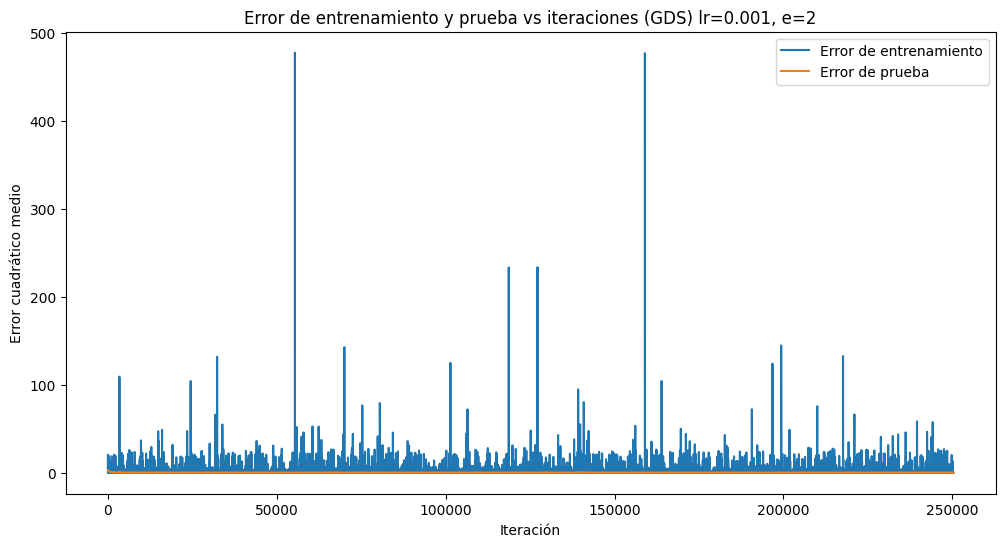

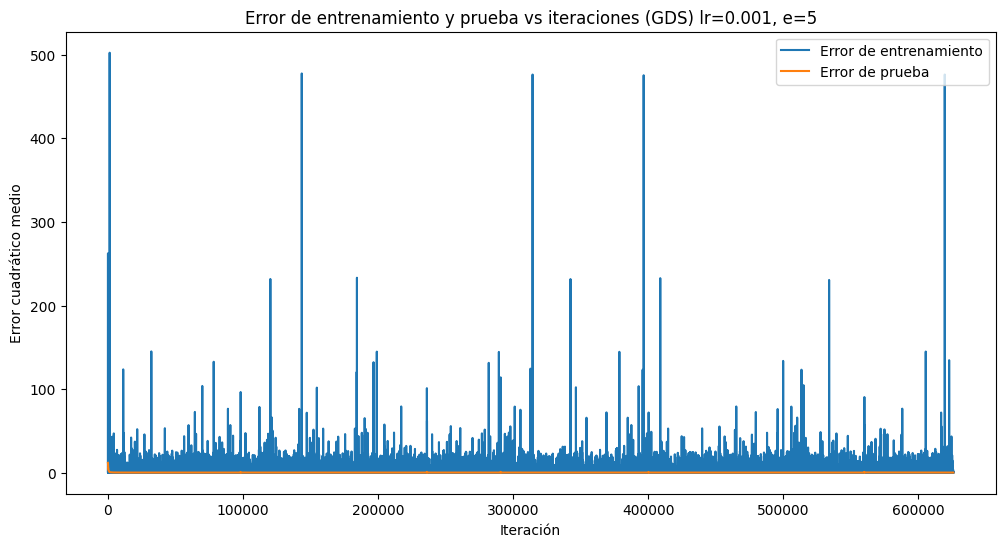

In [262]:
# Probamos distintos epochs para ver su impacto en el error
epochs_list = [2, 5]

for epochs in epochs_list:
    coef_gradiente = gradiente_descendiente_estocastico(
        x_train_gd, y_train_gd, x_val_gd, y_val_gd,
        epochs=epochs,
        lr=0.001
    )

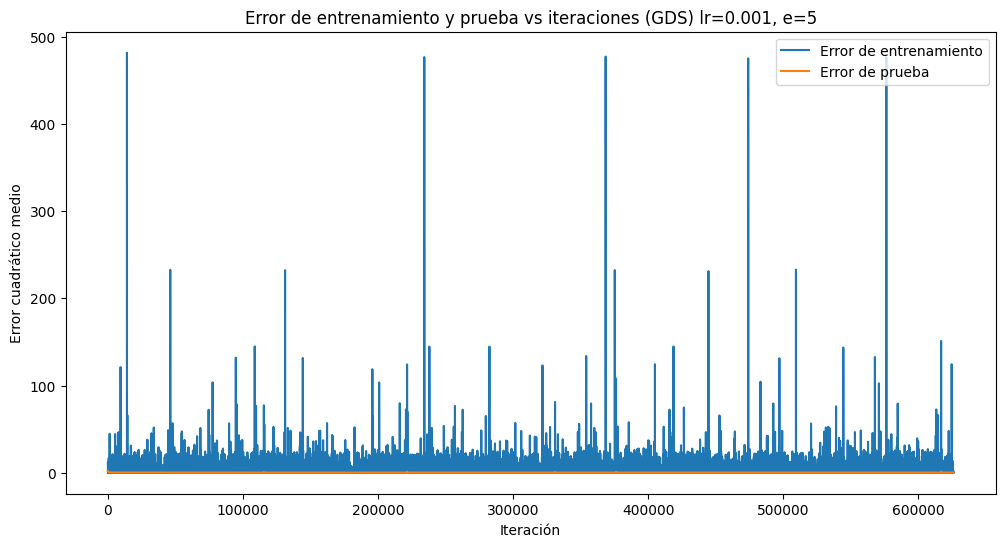

In [263]:
# Nos quedamos con el mejor hiperparámetro y entrenamos el modelo
coef_GDS = gradiente_descendiente_estocastico(x_train_gd, y_train_gd, x_val_gd, y_val_gd, lr=0.001,  epochs=5)

In [264]:
# Evaluamos el modelo en el conjunto de test
X_test_gd = np.hstack((np.ones((X_test.shape[0], 1)), X_test.values))
y_pred_gd = np.matmul(X_test_gd, coef_GDS)
y_pred_gd_descaled = scaler_y.inverse_transform(y_pred_gd.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_gd_descaled)
rmse_GDS = np.sqrt(mse)
R2_GDS = r2_score(y_test, y_pred_gd_descaled)


print(f"El RMSE es: {rmse_GDS}")
print(f"R2: {R2_GDS}")

El RMSE es: 4.666570092981431
R2: 0.7632992553432413


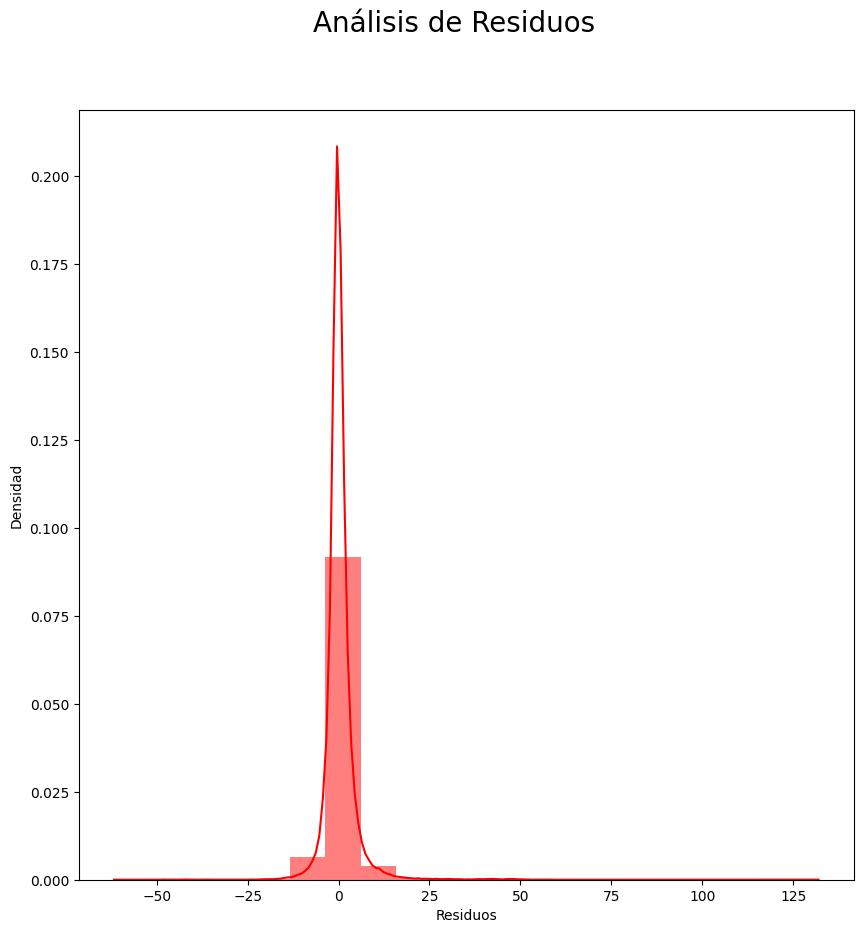

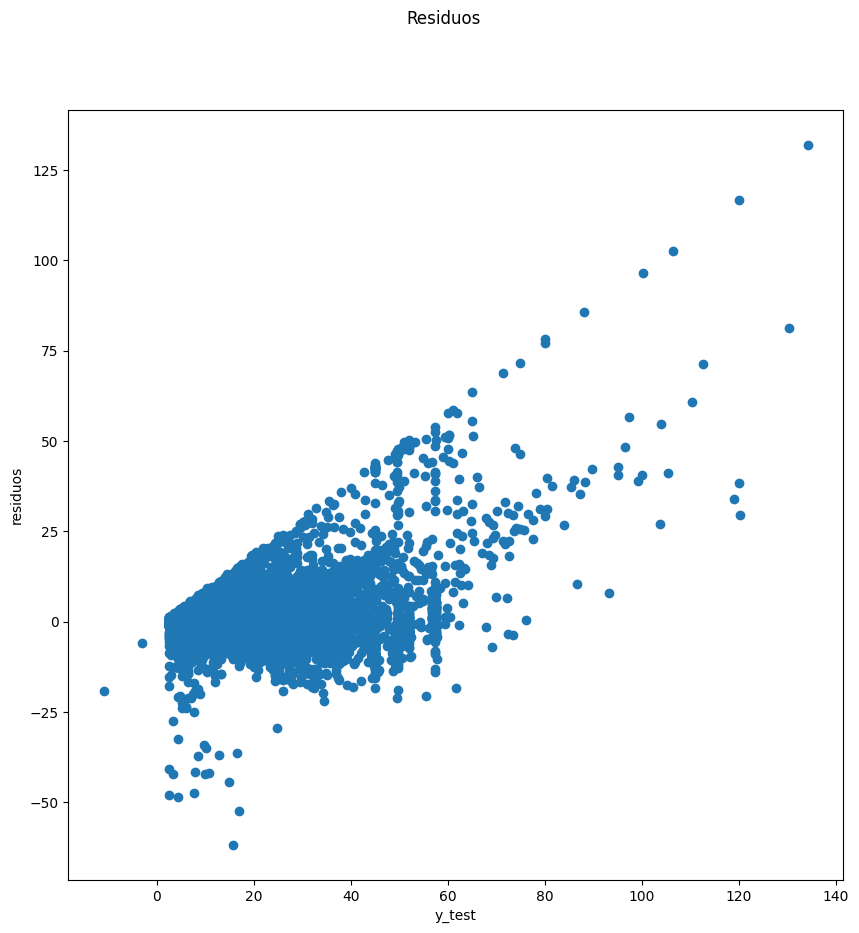

In [265]:
# Analizamos los residuos
fig = plt.figure(figsize=(10,10))
residuos = y_test - y_pred_gd_descaled.reshape(y_test.shape)
sns.histplot(residuos, color="red", kde=True, stat="density", linewidth=0, bins=20)
fig.suptitle('Análisis de Residuos', fontsize=20)
plt.xlabel('Residuos')
plt.ylabel('Densidad')
plt.show()

fig = plt.figure(figsize=(10,10))
fig.suptitle('Residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test, y_test - y_pred_gd_descaled.flatten())
plt.show()

Podemos evidenciar que en el gráfico de residuos, el pico más alto de la distribución se encuentra cercano al cero. En principio, puede ser bueno, ya que, en promedio, la mayoría de sus errores son pequeños. Sin embargo, presenta una fuerte asimetría positiva lo que indica que el modelo comete algunos errores muy grandes, subestimando el valor real. Por lo tanto, no podríamos afirmar que es un modelo fiable.

In [266]:
# Probamos regresion con regularizacion Ridge
modelo = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
         )

_ = modelo.fit(X = X_train, y = y_train_scaled)

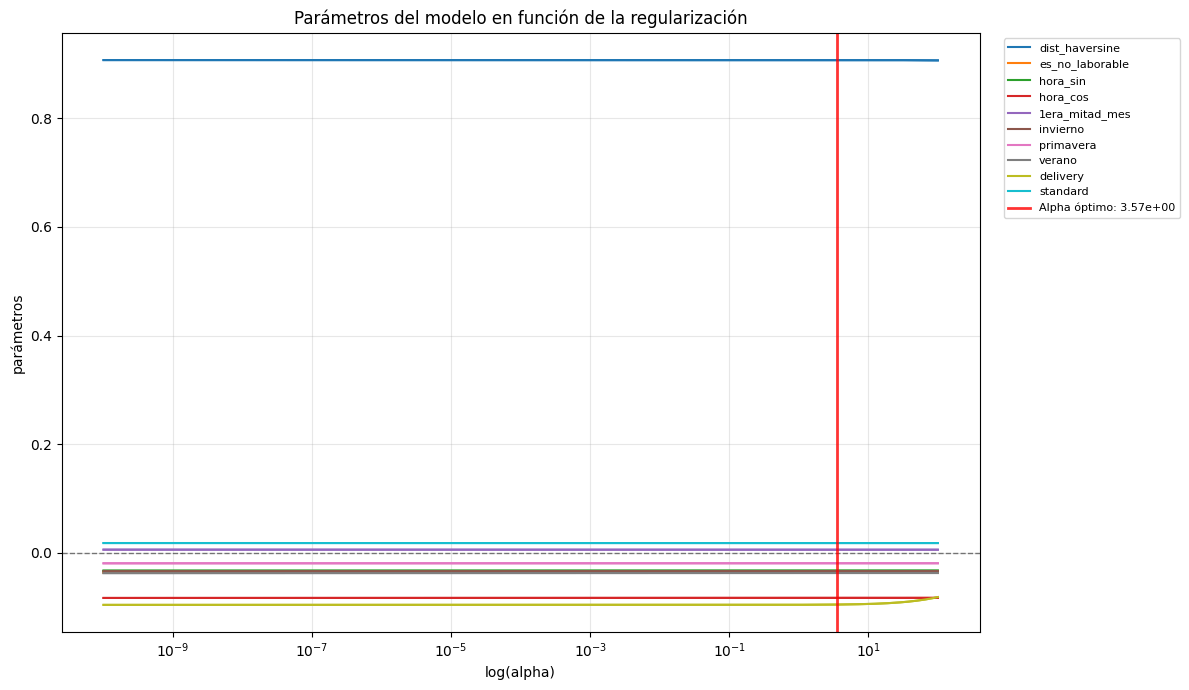

Mejor valor de alpha encontrado: 3.5707859649004554


In [267]:
# Buscamos el mejor alpha, entrenamos el modelo y graficamos los coeficientes
alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train_scaled)
    coefs.append(modelo_temp.coef_.flatten())

coefs = np.array(coefs)

fig, ax = plt.subplots(figsize=(12, 7))
for i, feature in enumerate(X_train.columns):
    ax.plot(alphas, coefs[:, i], label=feature)

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(x=modelo.alpha_, color='red', linestyle='-', alpha=0.8, linewidth=2, 
           label=f'Alpha óptimo: {modelo.alpha_:.2e}')

ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

El alpha óptimo produce poca contracción diferenciada, no hay coeficientes que se caigan drásticamente, señal de que Ridge penaliza de forma uniforme y ninguna variable es descartada, solo suavemente reducida.

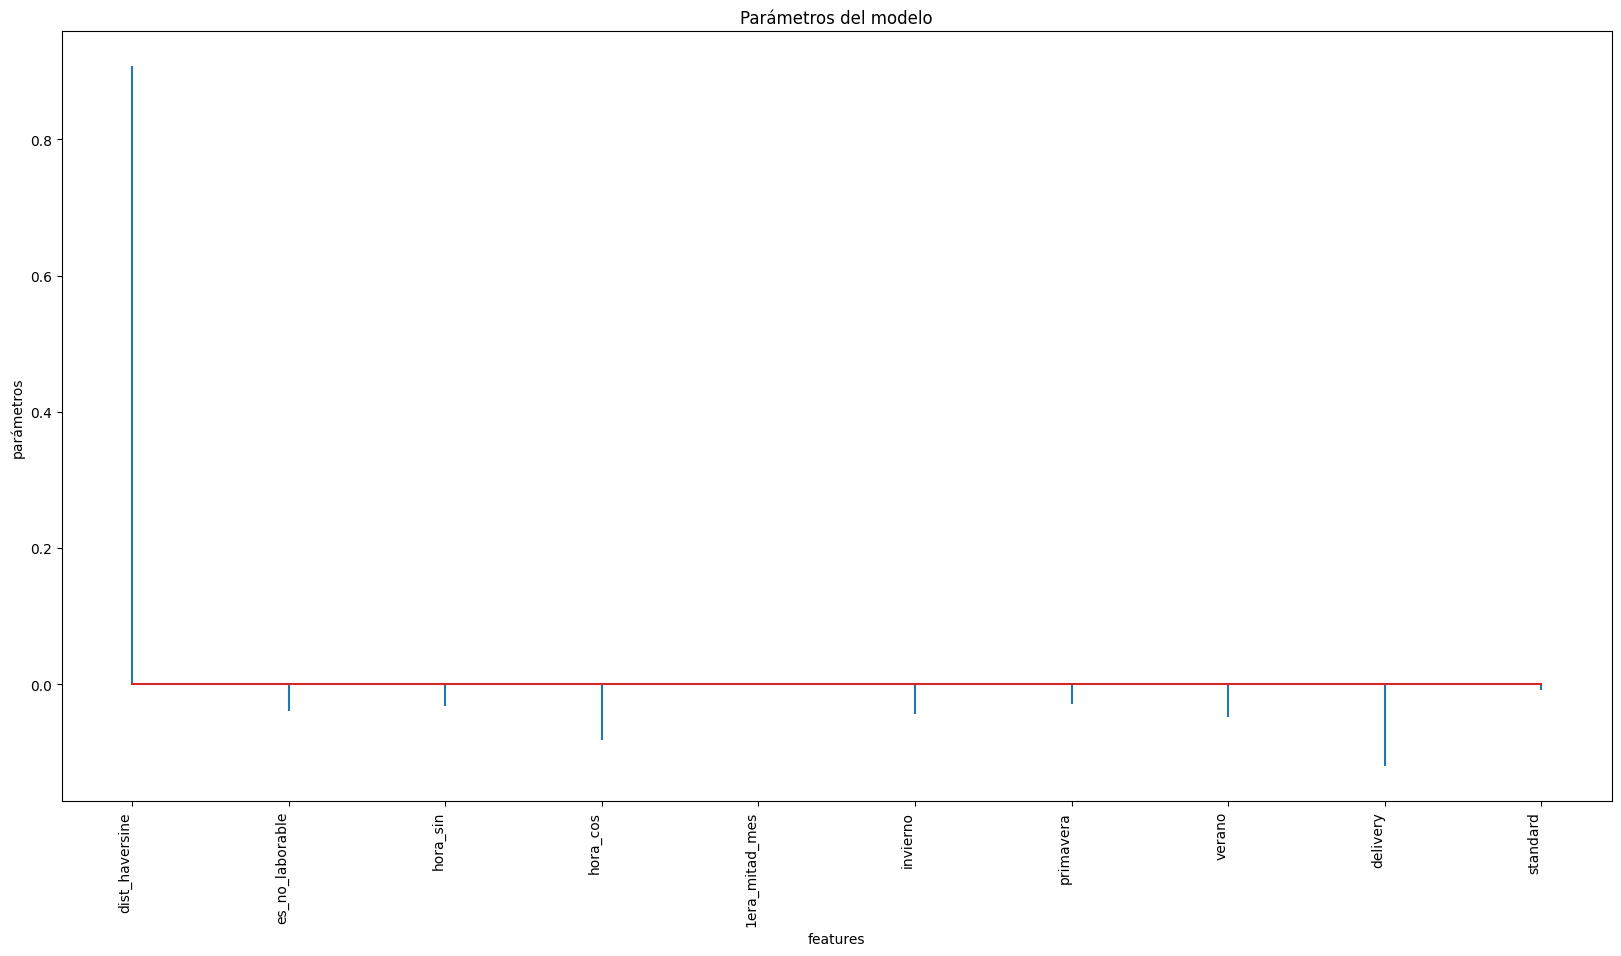

In [268]:
# Visualizamos los coeficientes del modelo

df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [269]:
# Evaluamos el modelo en el conjunto de test
predicciones = modelo.predict(X = X_test)
predicciones = predicciones.flatten()
predicciones_descaled = scaler_y.inverse_transform(predicciones.reshape(-1, 1))
rmse_ridge = np.sqrt(mean_squared_error(
    y_true=y_test_scaled,
    y_pred=predicciones_descaled,
))

print(f"El RMSE es: {rmse_ridge}")
R2_ridge = r2_score(y_test, predicciones_descaled)
print(f"R2 = {R2_ridge}")

El RMSE es: 13.52383045326088
R2 = 0.7674740464399363


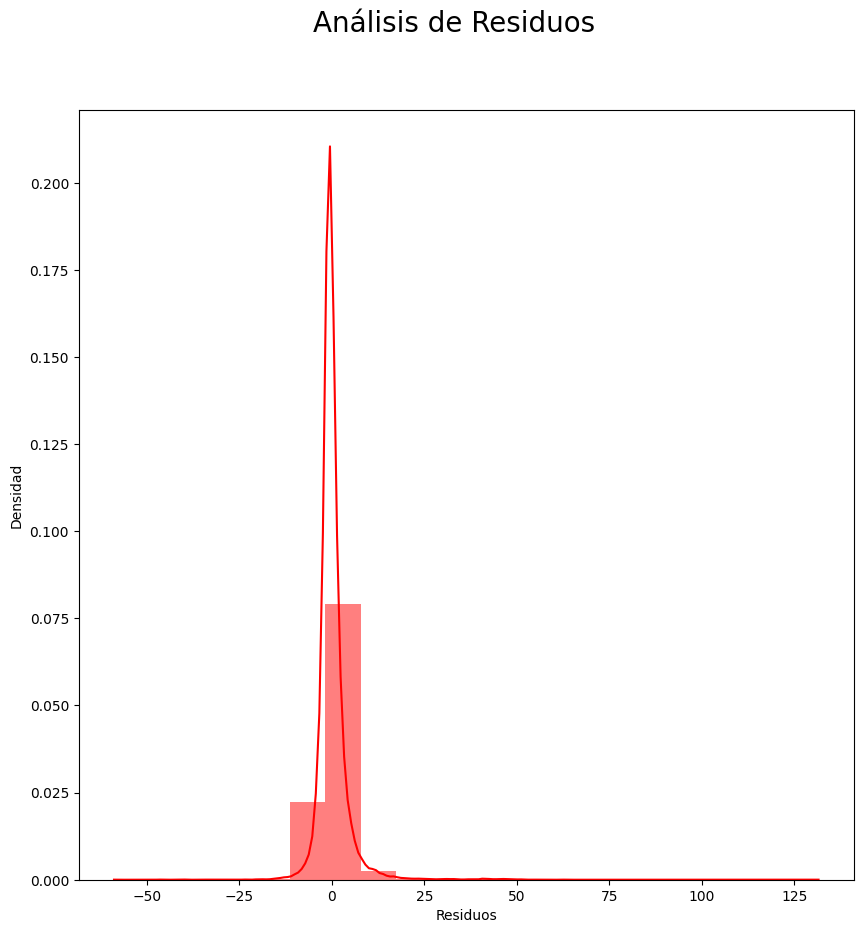

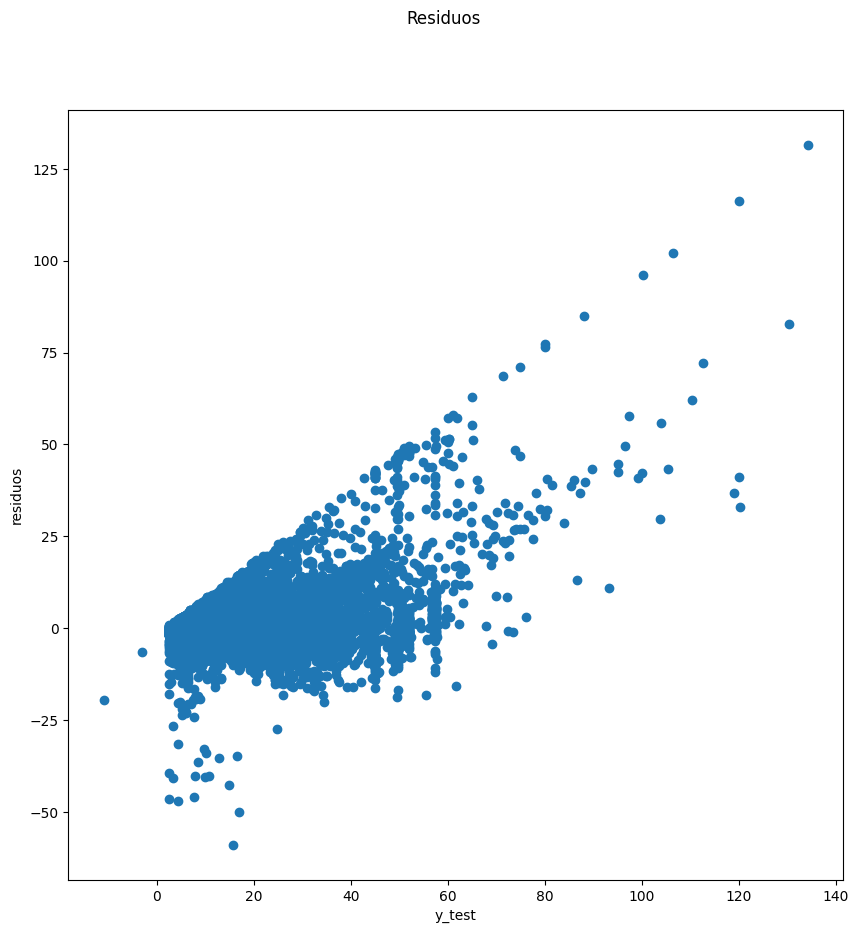

In [270]:
# Analisis de residuos
fig = plt.figure(figsize=(10,10))
residuos = y_test - predicciones_descaled.reshape(y_test.shape)
sns.histplot(residuos, color="red", kde=True, stat="density", linewidth=0, bins=20)
fig.suptitle('Análisis de Residuos', fontsize=20)
plt.xlabel('Residuos')
plt.ylabel('Densidad')
plt.show()

fig = plt.figure(figsize=(10,10))
fig.suptitle('Residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test, y_test - predicciones_descaled.flatten())
plt.show()

Podemos evidenciar que en el gráfico de residuos, el pico más alto de la distribución se encuentra cercano al cero. En principio, puede ser bueno, ya que, en promedio, la mayoría de sus errores son pequeños. Sin embargo, presenta una fuerte asimetría positiva lo que indica que el modelo comete algunos errores muy grandes, subestimando el valor real. Por lo tanto, no podríamos afirmar que es un modelo fiable.

In [271]:
# Probamos regresion con regularizacion Lasso
modelo = LassoCV(
            alphas          = np.logspace(-10, 3, 200),
            cv              = 10
         )

_ = modelo.fit(X = X_train, y = y_train_scaled.flatten())

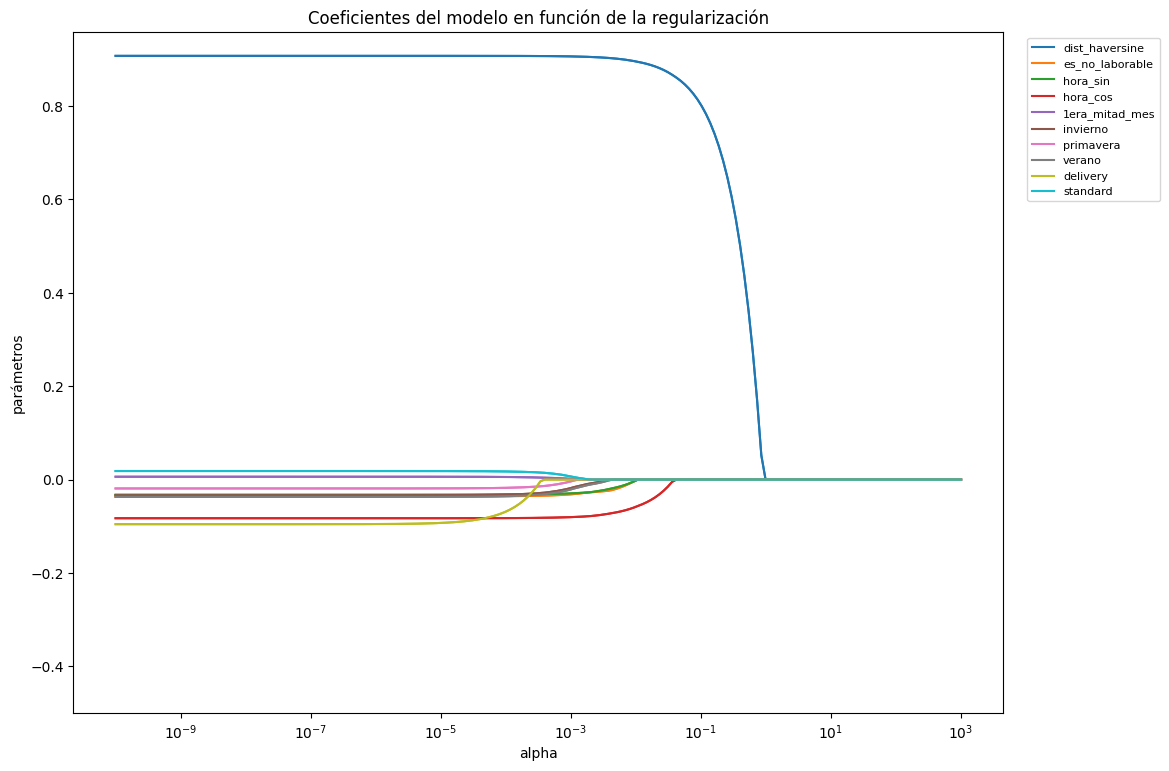

In [272]:
# Buscamos el mejor alpha, entrenamos el modelo y graficamos los coeficientes

alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train_scaled)
    coefs.append(modelo_temp.coef_.flatten())

coef_path = np.array(coefs)

fig, ax = plt.subplots(figsize=(12, 8.84))
for i, feature in enumerate(X_train.columns):
    ax.plot(alphas, coef_path[:, i], label=feature)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.set_title('Coeficientes del modelo en función de la regularización')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8);



Al aumentar alpha (eje x logarítmico) los coeficientes de Lasso se van contrayendo hacia el 0. Los que se aplanan en 0 primero son los menos influyentes y los que mantienen valor hasta alphas más grandes aportan más señal.

In [273]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 1e-10


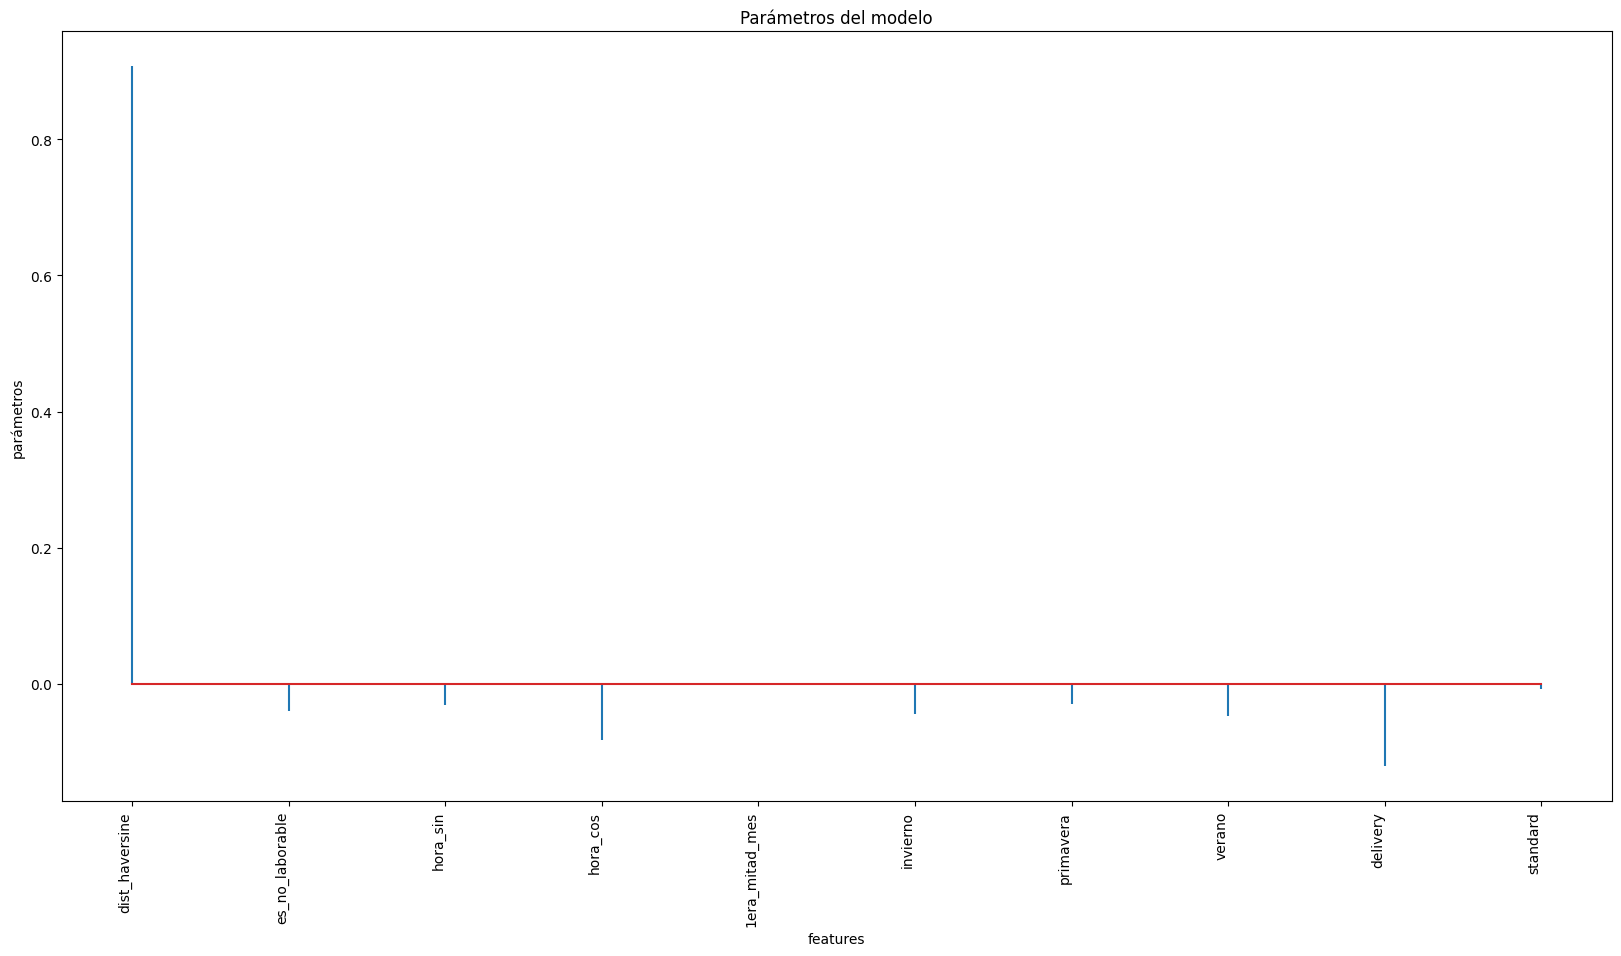

In [274]:
# Visualizamos los coeficientes del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [275]:
# Evaluamos el modelo en el conjunto de test
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones_descaled = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse_lasso = np.sqrt(mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones_descaled,
             ))

print(f"El RMSE es: {rmse_lasso}")
R2_lasso = r2_score(y_test, predicciones_descaled)
print(f"R2 = {R2_lasso}")

El RMSE es: 4.625236072704063
R2 = 0.767473826105333


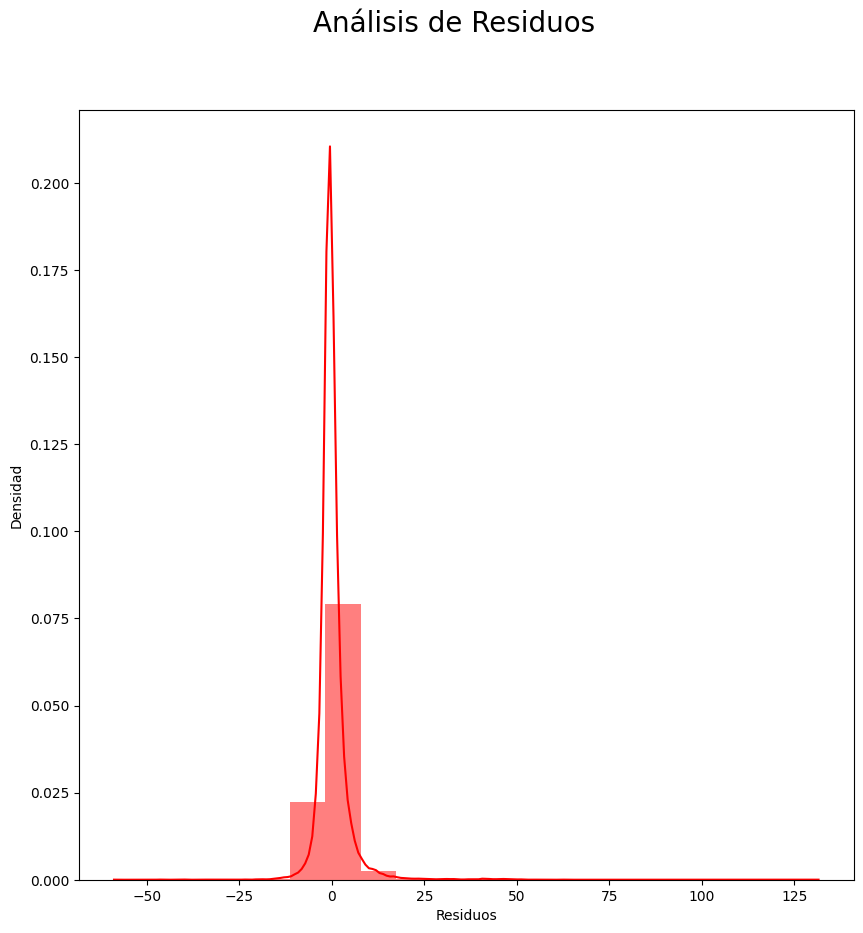

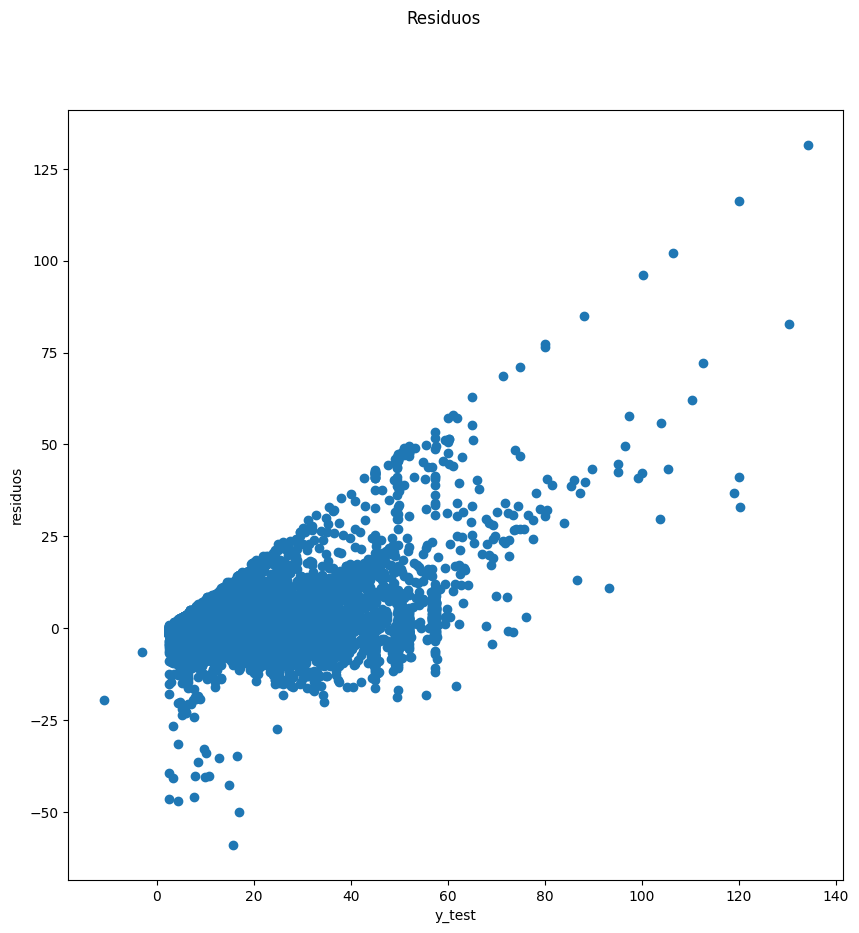

In [276]:
# Analisis de residuos
fig = plt.figure(figsize=(10,10))
residuos = y_test - predicciones_descaled.reshape(y_test.shape)
sns.histplot(residuos, color="red", kde=True, stat="density", linewidth=0, bins=20)
fig.suptitle('Análisis de Residuos', fontsize=20)
plt.xlabel('Residuos')
plt.ylabel('Densidad')
plt.show()

fig = plt.figure(figsize=(10,10))
fig.suptitle('Residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test, y_test - predicciones_descaled.flatten())
plt.show()

Podemos evidenciar que en el gráfico de residuos, el pico más alto de la distribución se encuentra cercano al cero. En principio, puede ser bueno, ya que, en promedio, la mayoría de sus errores son pequeños. Sin embargo, presenta una fuerte asimetría positiva lo que indica que el modelo comete algunos errores muy grandes, subestimando el valor real. Por lo tanto, no podríamos afirmar que es un modelo fiable.

In [277]:
# Probamos regresion con regularizacion ElasticNet
modelo = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train_scaled.flatten())

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.032e+04, tolerance: 1.408e+01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coo

In [278]:
# Mejor valor alpha y l1_ratio_ encontrado

print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo.l1_ratio_}")

Mejor valor de alpha encontrado: 1e-10
Mejor valor de l1_ratio encontrado: 0.0


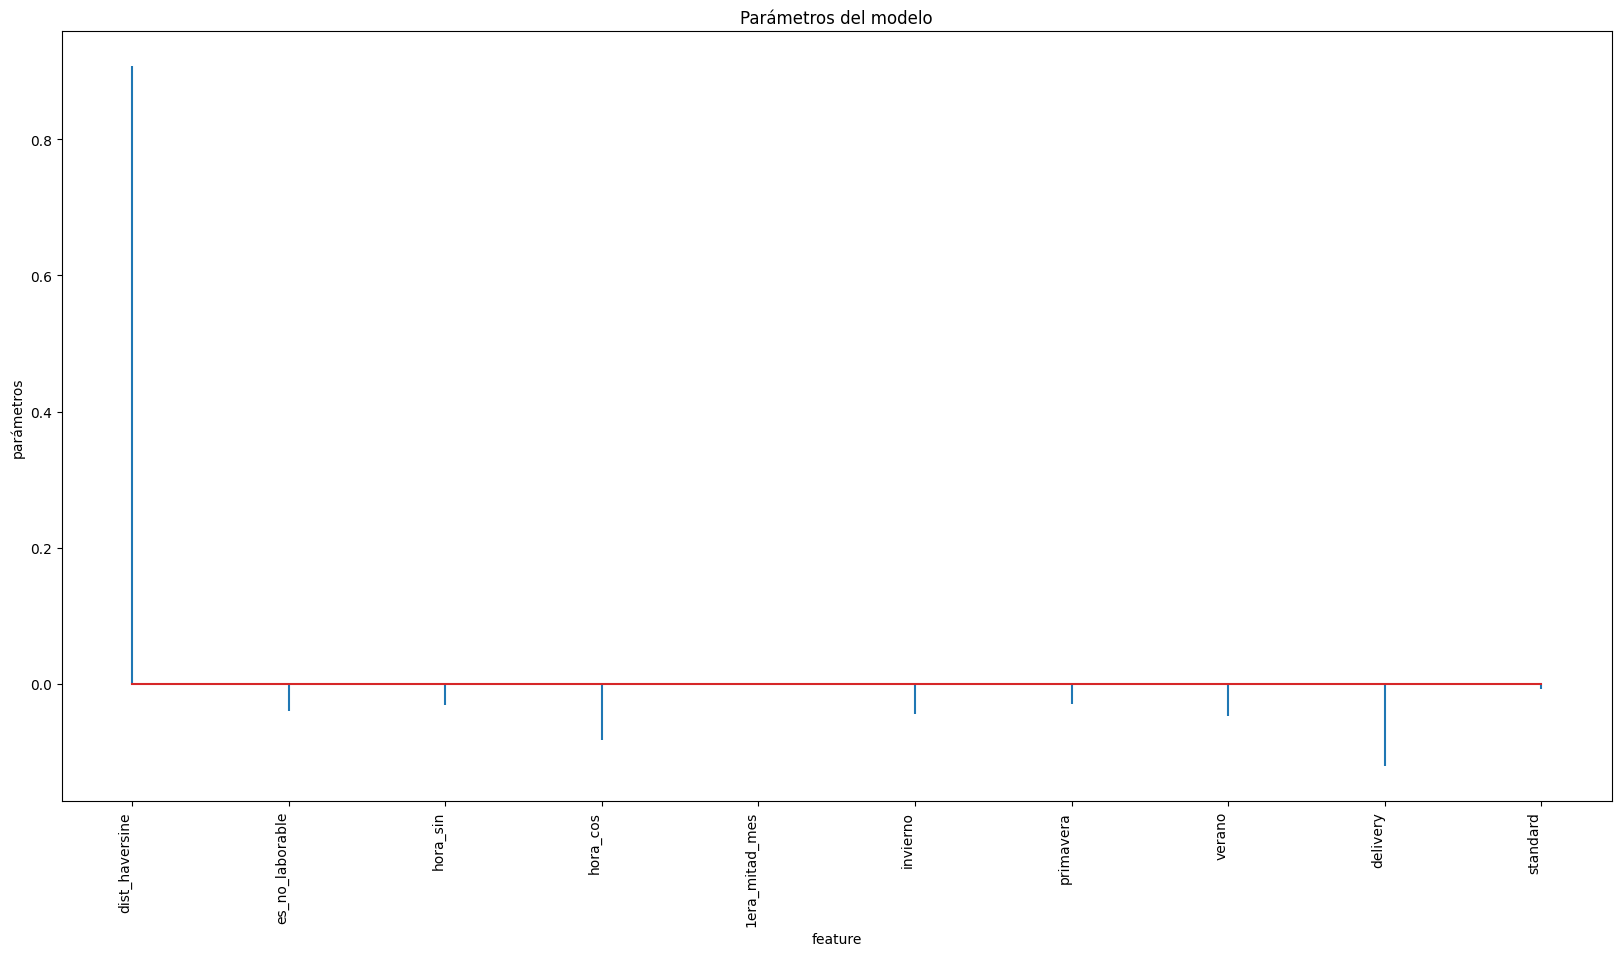

In [279]:
# Visualizamos los coeficientes del modelo
df_coeficientes = pd.DataFrame(
    {
        'predictor': X_train.columns,
        'coef': modelo.coef_.flatten()
    }
)

fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

In [280]:
# Evaluamos el modelo en el conjunto de test

predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones_descaled = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse_elastic = np.sqrt(mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones_descaled,
               ))

print(f"El RMSE es: {rmse_elastic}")
R2_elastic = r2_score(y_test, predicciones_descaled)
print(f"R2 = {R2_elastic}")

El RMSE es: 4.625236072598961
R2 = 0.7674738261159006


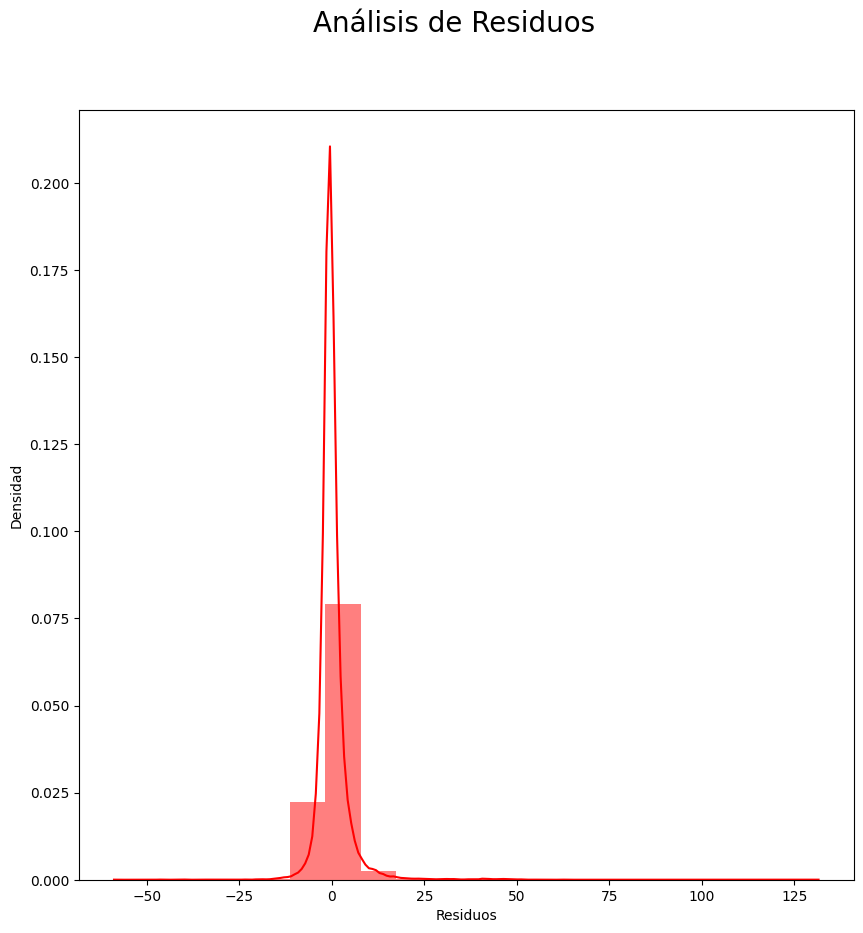

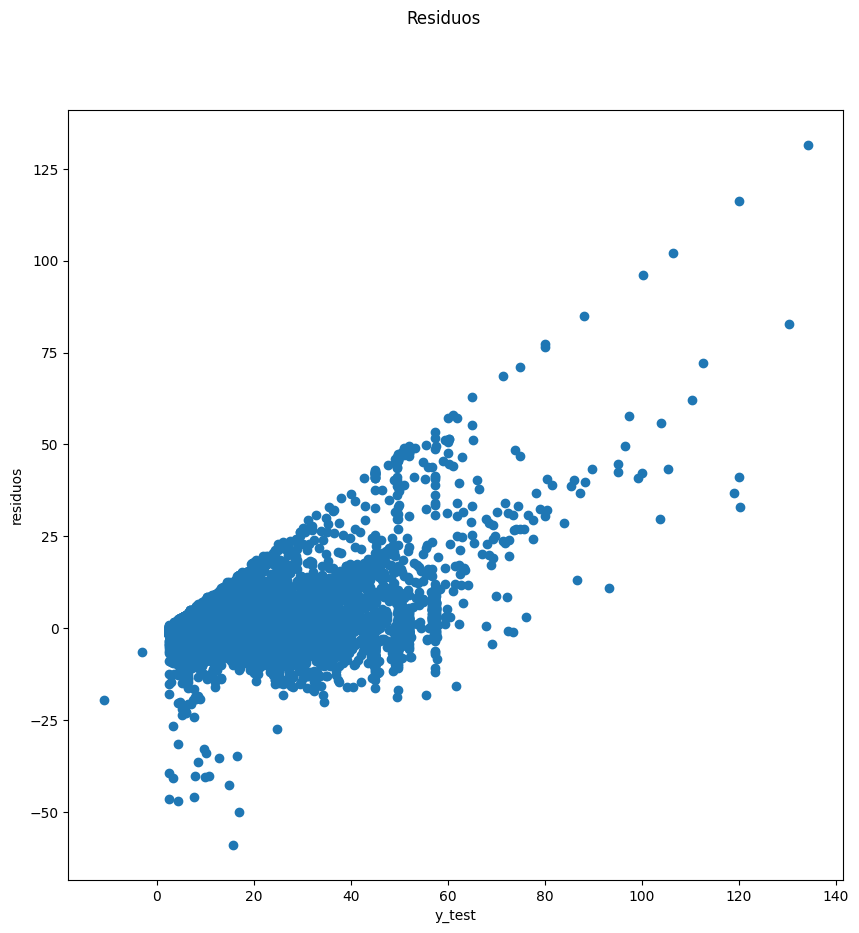

In [281]:
# Analizamos los residuos
fig = plt.figure(figsize=(10,10))
residuos = y_test - predicciones_descaled.reshape(y_test.shape)
sns.histplot(residuos, color="red", kde=True, stat="density", linewidth=0, bins=20)
fig.suptitle('Análisis de Residuos', fontsize=20)
plt.xlabel('Residuos')
plt.ylabel('Densidad')
plt.show()

fig = plt.figure(figsize=(10,10))
fig.suptitle('Residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test, y_test - predicciones_descaled.flatten())
plt.show()

Podemos evidenciar que en el gráfico de residuos, el pico más alto de la distribución se encuentra cercano al cero. En principio, puede ser bueno, ya que, en promedio, la mayoría de sus errores son pequeños. Sin embargo, presenta una fuerte asimetría positiva lo que indica que el modelo comete algunos errores muy grandes, subestimando el valor real. Por lo tanto, no podríamos afirmar que es un modelo fiable.

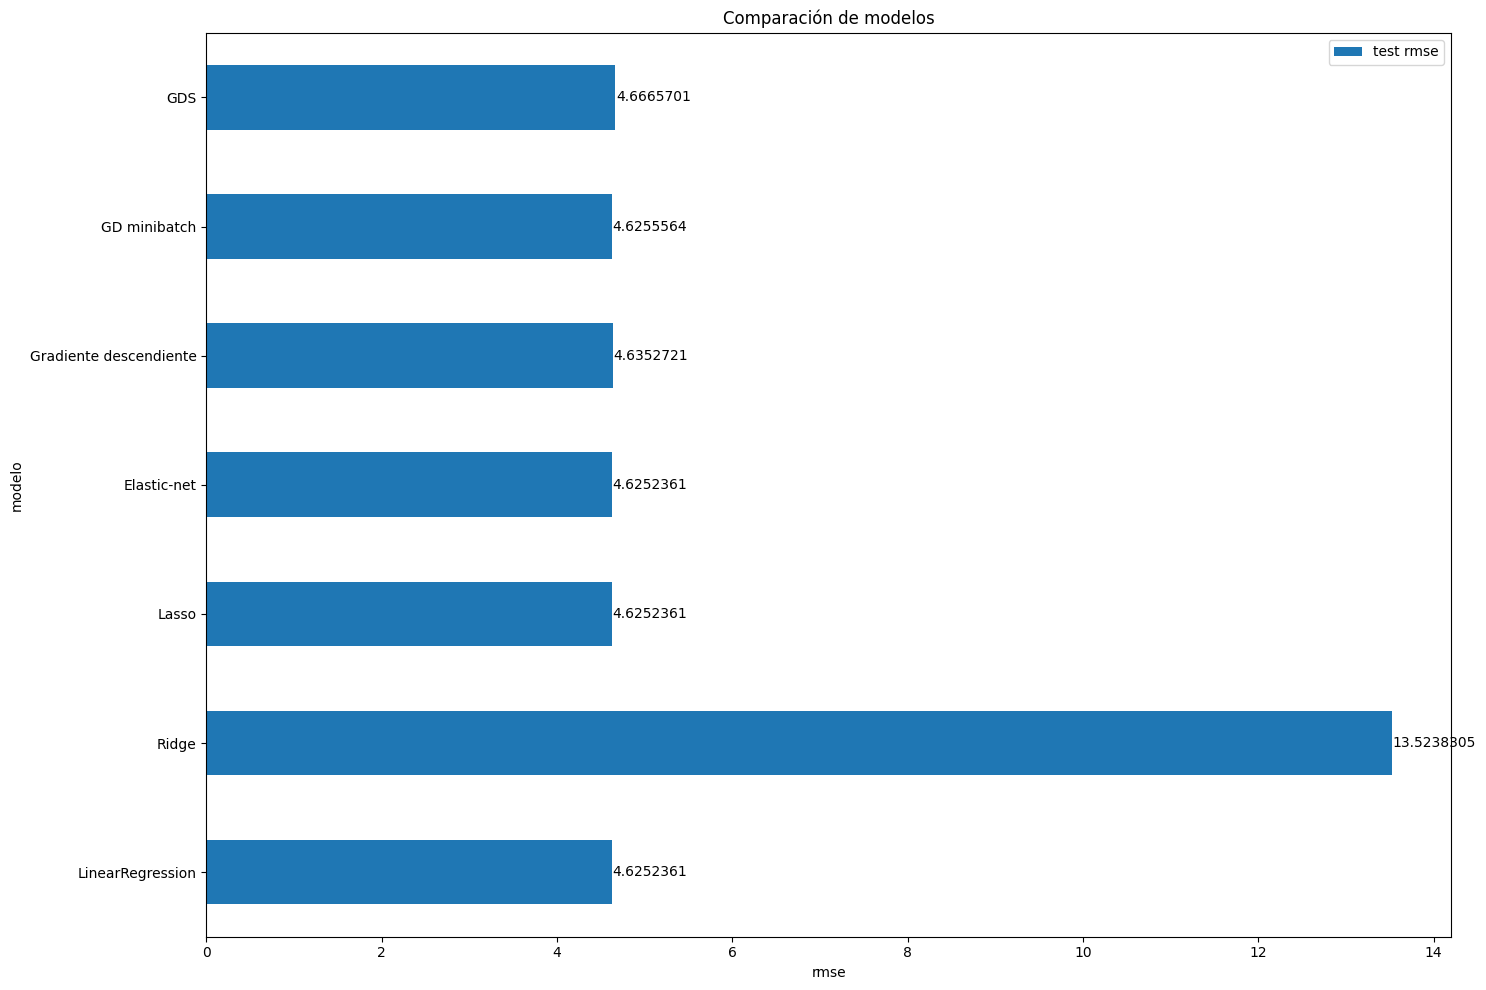

In [282]:
# Comparamos los distintos modelos utilizando RMSE
df_comparacion = pd.DataFrame({
                    'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'Elastic-net','Gradiente descendiente','GD minibatch','GDS'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic, rmse_gd, rmse_gmini, rmse_GDS],
                 })

fig, ax = plt.subplots(figsize=(15, 10))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos')

for i, (modelo, rmse) in enumerate(zip(df_comparacion['modelo'], df_comparacion['test rmse'])):
    ax.text(rmse + 0.01, i, f'{rmse:.7f}', va='center', fontsize=10)

plt.tight_layout()
plt.show();

En base a la comparación de la métrica elegida, se evidencia que el modelo de regresión Lasso, tiene mejor fitting, aunque sea por un margen muy pequeño.

Conclusión:
Podemos concluir que no hemos conseguido un buen fitting para el objetivo buscado debido a que, a pesar de probar los múltiples métodos de regresión propuestos, el desempeño del modelo se estancó en un RMSE que casi no difiere y los residuos muestran patrones y sesgo considerables. El modelo no aprende bien de tarifas altas y posee heterocedasticidad.